## Exploratory Data Analysis
#### Author: `SOFIIA BUDILOVA`

## <center>План</center>

#### [Вступ](#start)

#### [Переробка таблиці](#table_remake)

#### [Відповіді на питання](#questions)

1 [Яка середня кількість моїх повідомлень у групи й у приватні чати?](#mean)

2 [Яка середня довжина повідомлень, які я відправляю та отримую?](#mean2)

3 [Яка середня довжина пересланих повідомлень, які я відправляю та отримую?](#fwd_length)

4 [Звідки зазвичай переслані повідомлення, від людей чи з каналів?](#fwd_from_whom)

5 [Кількість пересланих повідомлень за датою](#fwd_by_date)

6 [Коли я лягаю спати та коли встаю?](#sleep)

7 [У який час доби я пишу більше, а у який - менше?](#sleep2)

8 [З ким переписок більше за гендером?](#gender)

9 [З ким за гендером в мене більше переписок у який період часу?](#gender_date)

10 [Якою мовою зазвичай листування?](#language)

11 [Хто пише більше під час переписки, я чи людина, з якою я розмовляю?](#who_writes_more)

12 [Хто частіше пише першою, я чи людина, з якою я розмовляю?](#who_writes_first)

13 [Які теми зазвичай у переписках?](#topics)

#### [Аналіз переписок з друзями](#friends)

14 [Які найбільш використовувані слова в листуванні?](#words)

15 [А якими є найбільш використовувані пари слів?](#bigrams)

16 [Частота використання слів, пов'язаних із навчанням](#studying)

17 [Частота використання позитивно- та негативнозабарвлених емоційних слів](#pos_and_neg)

19 [Частота використання слів, пов'язаних зі студентстьким життям](#naukma)

20 [Частота використання слів, пов'язаних із виїздом з окупованих територій](#war)

21 [Погляньмо на найбільш використовувані смайлики](#emojis)

22 [Які смайликі трапляються в усіх 4 чатах?](#emojis2)

23 [Яких смайликів більше: позитивних чи негативних?](#emojis3)

24 [Сентиментальний аналіз](#sentiment)

25 [Коли ми найбільше спілкувалися?](#speaking)

26 [Які іменовані сутності найбільш поширені у переписках?](#ner)

 <a id='start'></a>

## Вступ

У цій частині знаходиться код, спільний для різних питань, тому бажано запустити усі клітинки, починаючи з цієї, закінчуючи клітинкою 'Злиття df і df_meta'

In [1]:
import pandas as pd

In [2]:
DIALOGS_MERGED_DATA_PATH = '../data/merged_data/modified_dialogs_data_all.csv'
DIALOGS_META_MERGED_DATA_PATH = '../data/merged_data/modified_dialogs_users_all.csv'

In [3]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH, low_memory=False)
df_meta = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH)

In [4]:
my_id ='584223078'

In [5]:
my_id_str = f'PeerUser(user_id={my_id})'

In [6]:
df.shape

(964527, 14)

In [7]:
df_meta.shape

(5769, 5)

### Імпорти

In [8]:
import json
import emoji
import re
import string
import requests
import csv
import os

In [9]:
import datetime as dt
from pytz import timezone, all_timezones

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
import matplotlib.dates as mdates

In [11]:
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import stanza
from stanza.models.common.doc import Document
from stanza.pipeline.core import Pipeline

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import math

### Функції

In [14]:
def unique(list1):
    return np.unique(np.array(list1)).tolist()

In [15]:
def get_id(name):
    if (type(name) == int): return name
    else: 
        id = df_meta.loc[df_meta['name'].str.contains(name, regex=True)]['dialog_id']
        if id.size > 1: return 'Є декілька діалогів, що містять в імені заданий рядок, передайте як параметр id діалогу'
        return int(id)

In [16]:
# get_xy_from_dict
def get_x_y(number_of_messages):
    lists1 = sorted(number_of_messages.items())
    x, y = zip(*lists1)
    return x, y

In [17]:
def get_messages(id):
    messages_df = df.loc[(df['dialog_id'] == id) & (df['type'] == 'text')].copy()
    messages_df.reset_index(inplace=True)
    return messages_df

<a id='table_remake'></a>

## Переробка таблиці

In [18]:
df['dialog_id'] = df['dialog_id'].apply(lambda x: int(x))

df_meta['dialog_id'] = df_meta['dialog_id'].apply(lambda x: int(x))

df['message']= df['message'].astype(str)

df['normalized'] = df['normalized'].astype(str)

### Злиття df і df_meta

In [23]:
df.columns

Index(['id', 'date', 'from_id', 'to_id', 'fwd_from', 'message', 'type',
       'duration', 'dialog_id'],
      dtype='object')

In [521]:
df_meta.columns

Index(['dialog_id', 'name', 'type', 'users', 'gender'], dtype='object')

In [156]:
df['dialog_name'] = [df_meta.loc[df_meta['dialog_id'] == df.loc[num, 'dialog_id']].reset_index().loc[0,'name']
                     if df_meta.loc[df_meta['dialog_id'] == df.loc[num, 'dialog_id']].size > 0
                     else None
                     for num in range(len(df))]

In [157]:
df['dialog_type'] = [df_meta.loc[df_meta['dialog_id'] == df.loc[num, 'dialog_id']].reset_index().loc[0,'type']
                     if df_meta.loc[df_meta['dialog_id'] == df.loc[num, 'dialog_id']].size > 0
                     else None
                     for num in range(len(df))]

In [194]:
df['gender'] = [df_meta.loc[df_meta['dialog_id'] == df.loc[num, 'dialog_id']].reset_index().loc[0,'gender']
                     if df_meta.loc[df_meta['dialog_id'] == df.loc[num, 'dialog_id']].size > 0
                     else None
                     for num in range(len(df))]

In [520]:
df.columns

Index(['id', 'date', 'from_id', 'to_id', 'fwd_from', 'message', 'type',
       'duration', 'dialog_id', 'dialog_name', 'dialog_type', 'gender'],
      dtype='object')

In [66]:
df.to_csv('../data/merged_data/modified_dialogs_data_all.csv', index = False, encoding='utf-8') 

<a id='questions'></a>

# Відповіді на питання
<a id='mean'></a>

### Яка середня кількість моїх повідомлень у групи й у приватні чати?

In [191]:
group_m = df.loc[(df['from_id'] == my_id_str) & (df['to_id'].str.contains('Chat|Channel', regex=True))]['id'].count()
private_m = df.loc[(df['from_id'] == my_id_str) & (~df['to_id'].str.contains('Chat|Channel', regex=True))]['id'].count()

In [192]:
group_amount = df_meta.loc[df_meta['type'].str.contains('Group|Channel', regex=True)]['name'].unique().size # кількість груп
private_amount = df_meta.loc[df_meta['type'] == 'Private dialog']['name'].unique().size # кількість приватних листувань

In [193]:
group_mean = group_m / group_amount
private_mean = private_m / private_amount

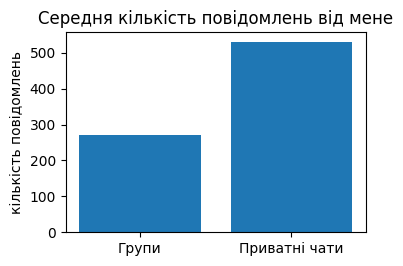

In [194]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
fig.set_size_inches(3,2)
x = ['Групи', 'Приватні чати']
y = [group_mean, private_mean]
ax.bar(x,y)
plt.title("Середня кількість повідомлень від мене")
plt.ylabel('кількість повідомлень')
plt.show()

In [195]:
private_mean / group_mean

1.9535837717237614

Отже, в приватні повідомлення я відправляю майже удвічі більше, тобто мені комфортніше спілкуватися з людиною сам на сам, ніж у групі людей

<a id='mean2'></a>

### Яка середня довжина повідомлень, які я відправляю та отримую?

In [20]:
def create_len_dict(borders):
    length_dict = {}
    
    length_dict[f'x≤{borders[0]}'] = 0
    for i in range(0, len(borders)-1):
        length_dict[f'{borders[i]}<x≤{borders[i+1]}'] = 0
    length_dict[f'x>{borders[-1]}'] = 0
    
    return length_dict

In [22]:
def length_func(text, length_dict, borders):
    if len(text) <= borders[0]: 
        length_dict[f'x≤{borders[0]}'] += 1
        return
    
    for i in range(1, len(borders)):
        if len(text) <= borders[i]:
            length_dict[f'{borders[i-1]}<x≤{borders[i]}'] += 1
            return
    
    length_dict[f'x>{borders[-1]}'] += 1    

In [31]:
borders = [3,15,50,200]
length_to_me = create_len_dict(borders)
length_from_me = create_len_dict(borders)

In [28]:
messages_to_me = df.loc[(df['type'] == 'text') & (df['dialog_type'] == 'Private dialog') & (df['to_id'] == my_id)]\
                ['message']
messages_from_me = df.loc[(df['type'] == 'text') & (df['dialog_type'] == 'Private dialog') & (df['from_id'] == my_id_str)]\
                ['message']

In [ ]:
messages_to_me.apply(length_func, args=(length_to_me, borders))
messages_from_me.apply(length_func, args=(length_from_me, borders))

In [63]:
def draw_plot(length_to_me, length_from_me, title=None):
    barWidth = 0.25
    fig = plt.subplots(figsize =(7, 4))
    num = len(length_to_me)

    br1 = range(num)
    br2 = [x + barWidth for x in br1]

    plt.bar(br1, list(length_to_me.values()), width = barWidth,
            color ='#58508d', label ='відправлені')
    plt.bar(br2, list(length_from_me.values()), width = barWidth,
            color ='#bc5090', label ='отримані')

    plt.xlabel('довжина повідомлення', fontsize = 10)
    plt.ylabel('кількість повідомлень', fontsize = 10)
    plt.xticks([r + barWidth for r in range(num)],
               list(length_to_me.keys()))

    plt.title(title)
    plt.legend()
    plt.show()

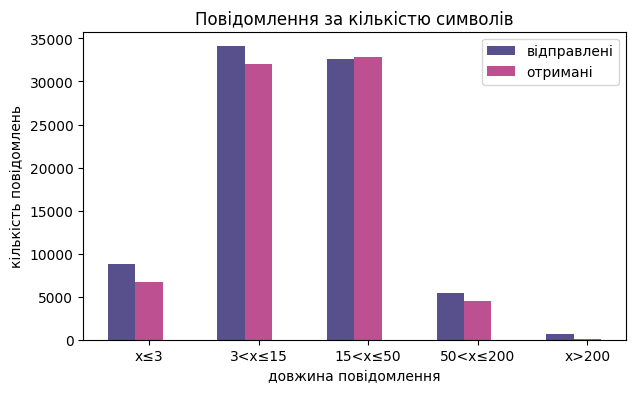

In [33]:
draw_plot(length_to_me, length_from_me, 'Повідомлення за кількістю символів')

Більша частина речень - це речення від 3 до 15, а також від 15 до 50

Велика кількість речень від 15 до 50 свідчить про спілкування повними реченнями з певною думкою. Проте так само багато речень коротких, які є радше відповідями на щось або короткими запитаннями

Також можна побачити, що відправлених повідомлень більше, ніж отриманих, що може бути пов'язаним з тим, що я радше пишу багато невеликих повідомлень з якоюсь думкою, ніж одне велике

<a id='fwd_length'></a>

### Яка середня довжина пересланих повідомлень, які я відправляю та отримую?

In [54]:
def create_len_dict(borders):
    length_dict = {}
    
    length_dict[f'x≤{borders[0]}'] = 0
    for i in range(0, len(borders)-1):
        length_dict[f'{borders[i]}<x≤{borders[i+1]}'] = 0
    length_dict[f'x>{borders[-1]}'] = 0
    
    return length_dict

In [55]:
def length_func(text, length_dict, borders):
    if len(text) <= borders[0]: 
        length_dict[f'x≤{borders[0]}'] += 1
        return
    
    for i in range(1, len(borders)):
        if len(text) <= borders[i]:
            length_dict[f'{borders[i-1]}<x≤{borders[i]}'] += 1
            return
    
    length_dict[f'x>{borders[-1]}'] += 1    

In [61]:
def draw_plot(length_to_me, length_from_me, title=None):
    barWidth = 0.25
    fig = plt.subplots(figsize =(7, 4))
    num = len(length_to_me)

    br1 = range(num)
    br2 = [x + barWidth for x in br1]

    plt.bar(br1, list(length_to_me.values()), width = barWidth,
            color ='#58508d', label ='відправлені')
    plt.bar(br2, list(length_from_me.values()), width = barWidth,
            color ='#bc5090', label ='отримані')

    plt.xlabel('довжина повідомлення', fontsize = 10)
    plt.ylabel('кількість повідомлень', fontsize = 10)
    plt.xticks([r + barWidth for r in range(num)],
               list(length_to_me.keys()))

    plt.title(title)
    plt.legend()
    plt.show()

In [57]:
borders = [3,15,50,200]
length_fwd_to_me = create_len_dict(borders)
length_fwd_from_me = create_len_dict(borders)

In [58]:
fwd_to_me =  df.loc[(df['type'] == 'text') & (df['dialog_type'] == 'Private dialog') & (df['to_id'] == my_id) &
                   (df['fwd_from'] == df['fwd_from'])]['message']
fwd_from_me =  df.loc[(df['type'] == 'text') & (df['dialog_type'] == 'Private dialog') & (df['from_id'] == my_id_str) &
                   (df['fwd_from'] == df['fwd_from'])]['message']

In [ ]:
fwd_to_me.apply(length_func, args=(length_fwd_to_me, borders))
fwd_from_me.apply(length_func, args=(length_fwd_from_me, borders))

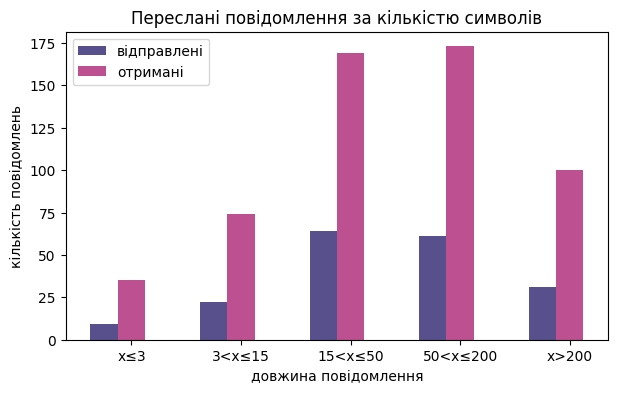

In [64]:
draw_plot(length_fwd_from_me, length_fwd_to_me, title='Переслані повідомлення за кількістю символів')

Отже, загалом я пересилаю менше, ніж пересилають мені, також можна побачити, що багато пересланих повідолмень мають велику довжину, до 200 символів, що може бути пов'язаним з тим, що в основному пересилають повідомлення від каналів, бо зазвичай у каналах повідомлення довші

<a id='fwd_from_whom'></a>

### Звідки зазвичай переслані повідомлення, від людей чи з каналів?

In [114]:
fwd_info = df.loc[(df['dialog_type'] == 'Private dialog') & (df['fwd_from'] == df['fwd_from'])].copy()
fwd_by = {}
fwd_by['me'] = fwd_info.loc[fwd_info['from_id'] == my_id_str]
fwd_by['others'] = fwd_info.loc[fwd_info['from_id'] != my_id_str]


def fwd_from_who(fwd_by):
    l = list(fwd_by['fwd_from'])
    from_id = [item.split('from_id=')[1].split('(')[0] for item in l]
    from_id = [item if not item.startswith('None') else 'PeerUser' for item in from_id]
    return from_id.count('PeerUser'), from_id.count('PeerChannel')

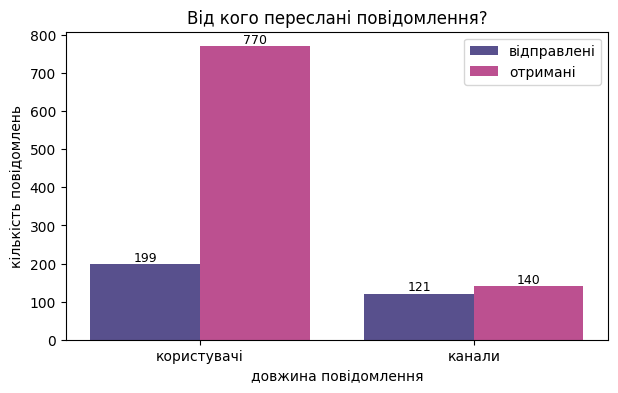

In [108]:
barWidth = 0.2
fig = plt.subplots(figsize =(7, 4))

br1 = np.arange(0.0, 1.0, 0.5)
br2 = [x + barWidth for x in br1]

bar1 = plt.bar(br1, fwd_from_who(fwd_by['me']), width = barWidth,
                color ='#58508d', label ='відправлені')
bar2 = plt.bar(br2, fwd_from_who(fwd_by['others']), width = barWidth,
                color ='#bc5090', label ='отримані')

plt.xlabel('довжина повідомлення', fontsize = 10)
plt.ylabel('кількість повідомлень', fontsize = 10)
plt.xticks([r + barWidth/2 for r in br1],
                   ['користувачі', 'канали'])

plt.bar_label(bar1, fontsize=9)
plt.bar_label(bar2, fontsize=9)

plt.title('Від кого переслані повідомлення?')
plt.legend()
plt.show()

Отже, виходить, на відміну від очікувань, що більше повідомлень пересилають від людей, а не з каналів

При цьому мені пересилають набагато більше повідомлень від користувачів, ніж пересилаю я

<a id='fwd_by_date'></a>

### Кількість пересланих повідомлень за датою

In [116]:
datetimes = [dt.datetime.fromisoformat(timestamp).astimezone(timezone('Europe/Kyiv')) for timestamp in fwd_info['date']]
fwd_info['date'] = [datetime.date() for datetime in datetimes]

dates = unique([datetime.date() for datetime in datetimes])

In [117]:
counters = {}
counters['fwd_by_me'] = [fwd_by['me'].loc[fwd_info['date'] == date].shape[0] for date in dates]
counters['fwd_by_others'] = [fwd_by['others'].loc[fwd_info['date'] == date].shape[0] for date in dates]

In [132]:
def draw_plot(x,y,title=None, size=(15,10)):    
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(size)
    ax = plt.subplot()

    ax.set_xlabel('роки', fontsize=16)
    ax.set_ylabel('кількість повідомлень', fontsize=16)
    ax.set_title(title, fontsize=20)

    ax.scatter(x, y)

    plt.show()

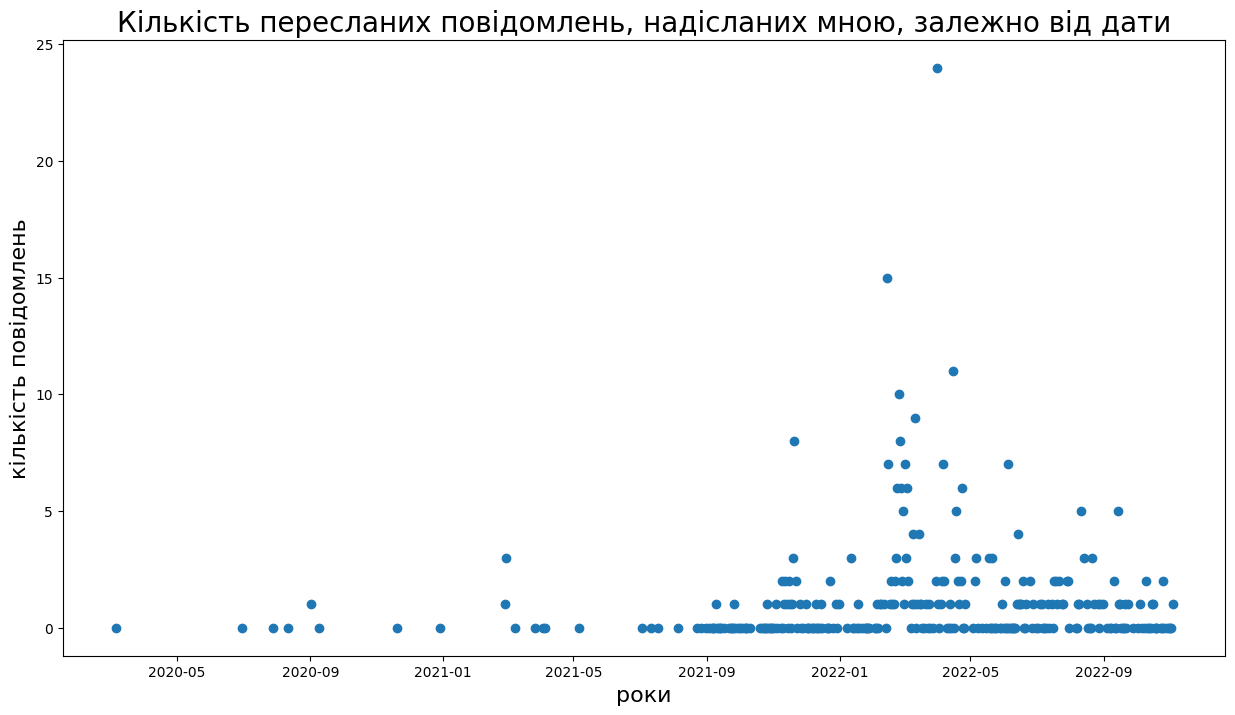

In [135]:
draw_plot(dates, counters['fwd_by_me'], 'Кількість пересланих повідомлень, надісланих мною, залежно від дати', (15, 8))

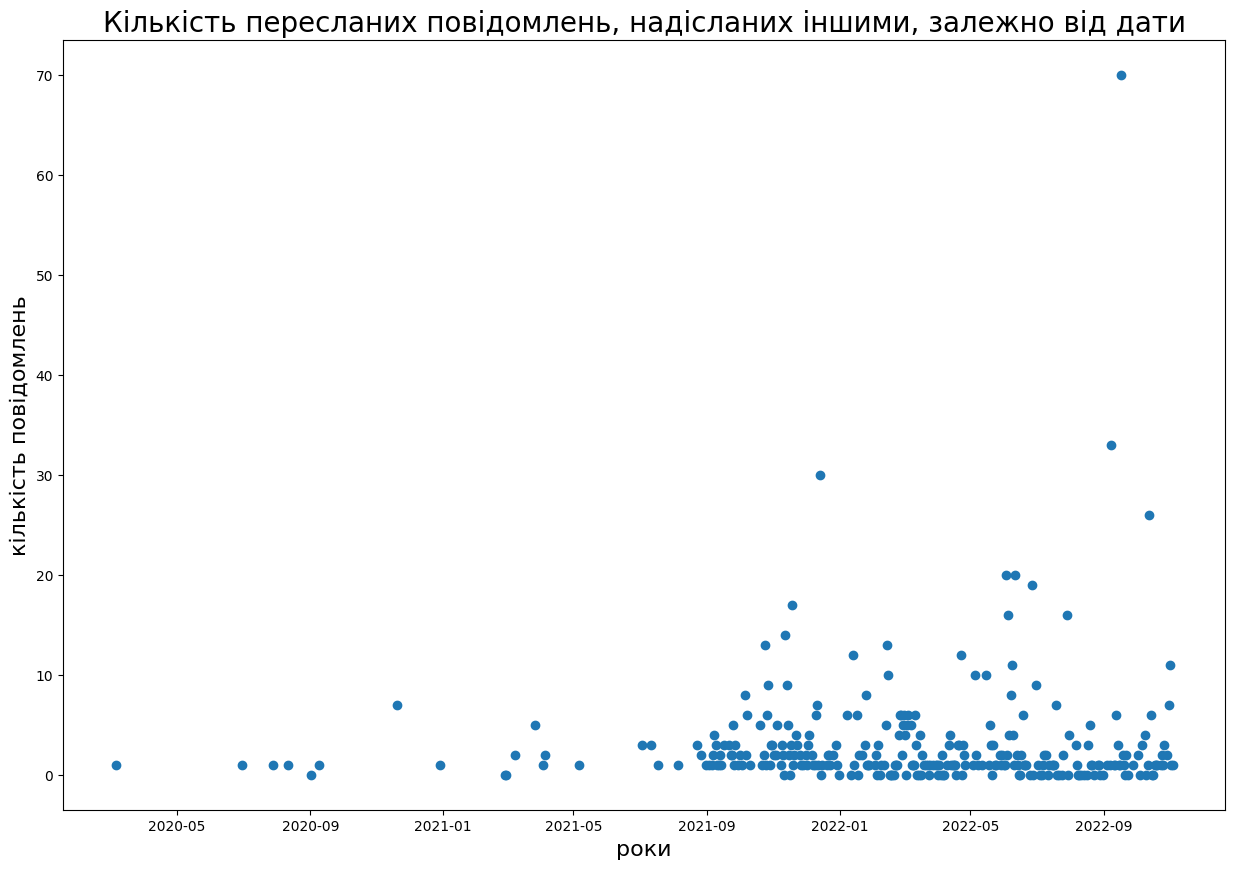

In [136]:
draw_plot(dates, counters['fwd_by_others'],\
          'Кількість пересланих повідомлень, надісланих іншими, залежно від дати',(15, 10))

Загалом тенденція така ж, як і з усіма повідомленнями. Тобто чим більше повідомлень загалом, тим більше повідомлень пересланих

<a id='sleep'></a>

### Коли я лягаю спати та коли встаю?

Аналіз на основі останніх відправлених вночі та перших відправлених зранку повідомлень

In [41]:
datetimes = sorted([dt.datetime.fromisoformat(timestamp).astimezone(timezone('Europe/Kyiv')) for timestamp in df.date])

dates = unique([datetime.date() for datetime in datetimes])

In [106]:
def tomorrow(date):
    return date + dt.timedelta(days=1)

Час прокидання

In [114]:
day_times = []

for datetime in datetimes:
    if datetime.time() > dt.time(4) and datetime.time() < dt.time(15):
        day_times.append(datetime)

In [120]:
day_maxes = []
null_date = dt.datetime(2030,1,1).astimezone(timezone('Europe/Kyiv'))
for date in dates:
    day_maxes.append(null_date)
    for day_time in day_times:
        if day_time.date() == date and day_time == min(day_time, day_maxes[-1]):
            day_maxes[-1] = day_time
    if day_maxes[-1] == null_date:
        del day_maxes[-1]

In [137]:
day_maxes = [time for time in day_maxes]

In [138]:
# d = day
d = [dt.datetime(2000,1,1,time.hour,time.minute,time.second,0).astimezone(timezone('Europe/Kyiv')) for time in day_maxes]

In [ ]:
x = pd.Series(d)
waking_up_mean = x.pipe(lambda d: (lambda m: m + (d - m).mean())(d.min())).to_pydatetime() # середній час

In [129]:
waking_up_mean.time() # datetime.time(8, 55, 9, 770214)

datetime.time(8, 55, 9, 770214)

In [130]:
d = [time.hour + time.minute/60 for time in d]

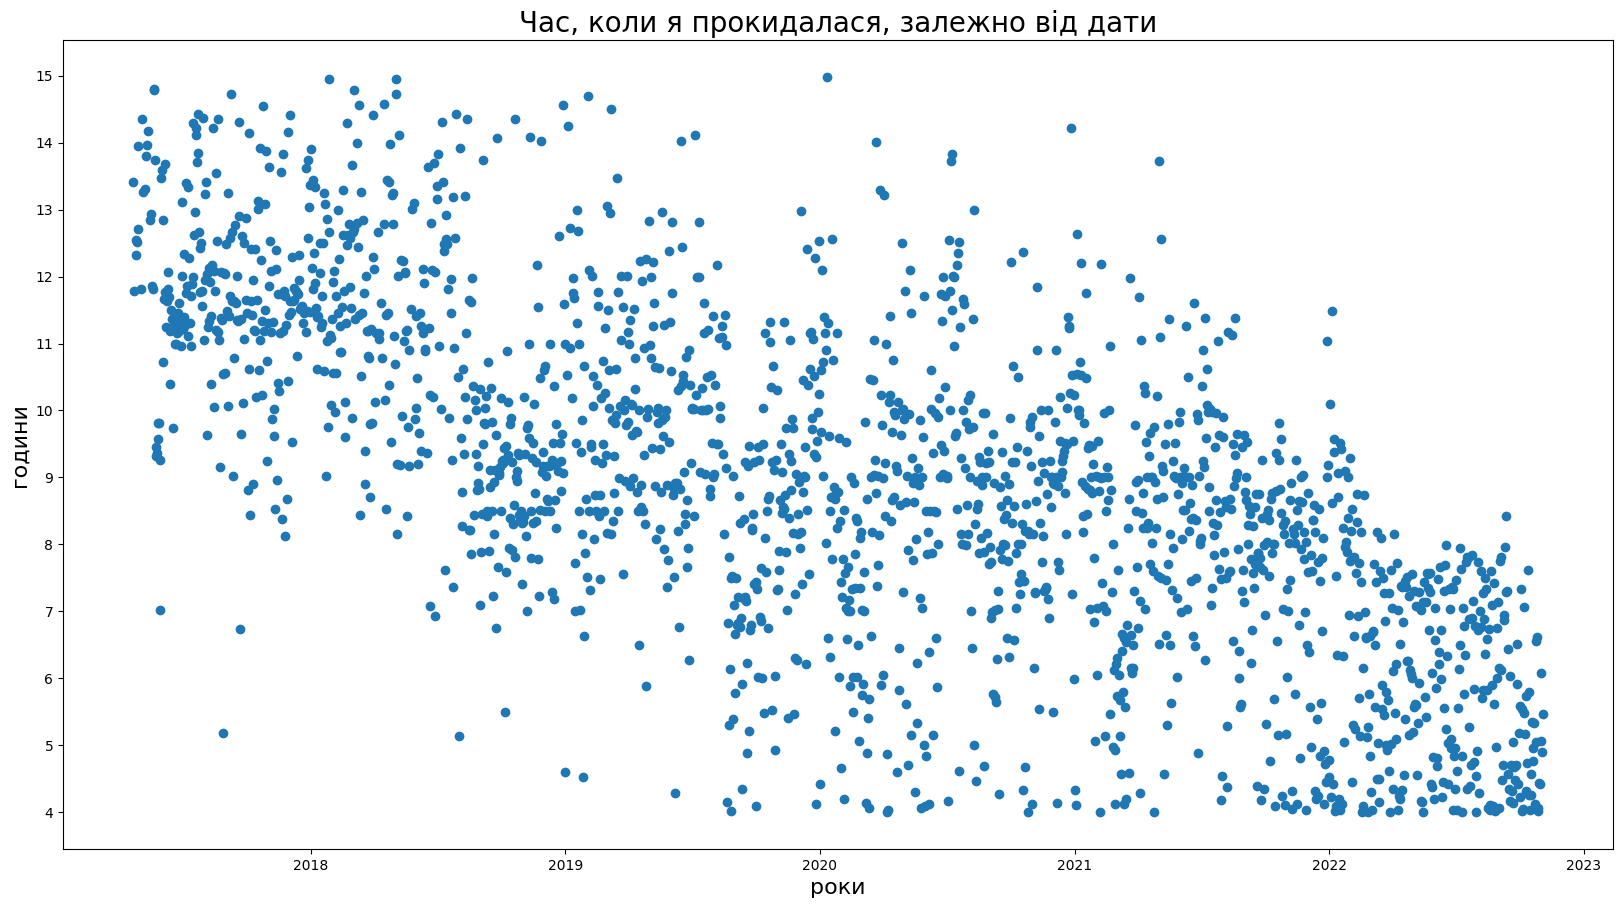

In [131]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10.5)
day_x = day_maxes
day_y = d
ax = plt.subplot()
ax.set_yticks([x for x in range(int(min(d)), int(max(d) + 2))])

ax.set_xlabel('роки', fontsize=16)
ax.set_ylabel('години', fontsize=16)
ax.set_title('Час, коли я прокидалася, залежно від дати', fontsize=20)

ax.scatter(day_x, day_y)
plt.show()

Час лягання спати

In [132]:
night_times = []

for datetime in datetimes:
    if datetime.time() > dt.time(21) or datetime.time() < dt.time(4):
        night_times.append(datetime)

In [ ]:
night_maxes = []
null_date = dt.datetime(2000,1,1).astimezone(timezone('Europe/Kyiv'))
for date in dates:
    night_maxes.append(null_date)
    for night_time in night_times:
        if night_time.date() == date or (night_time.date() == tomorrow(date) and night_time.time() < dt.time(4)):
            if night_time == max(night_time, night_maxes[-1]):
                night_maxes[-1] = night_time
    if night_maxes[-1] == null_date:
        del night_maxes[-1]

In [139]:
night_maxes = [time for time in night_maxes]

In [140]:
# n = night
n = [dt.datetime(2000,1,1,time.hour,time.minute,time.second,0).astimezone(timezone('Europe/Kyiv'))\
     if time.time() > dt.time(21)
     else dt.datetime(2000,1,2,time.hour,time.minute,time.second,0).astimezone(timezone('Europe/Kyiv'))\
     for time in night_maxes]

In [ ]:
x = pd.Series(n)
sleeping_mean = x.pipe(lambda d: (lambda m: m + (d - m).mean())(d.min())).to_pydatetime() # середній час

In [143]:
sleeping_mean.time() # datetime.time(0, 56, 50, 406904)

datetime.time(0, 56, 50, 406904)

In [144]:
n = [time.hour + time.minute/60 for time in n]

n = [-24+time if time>20 else time for time in n]

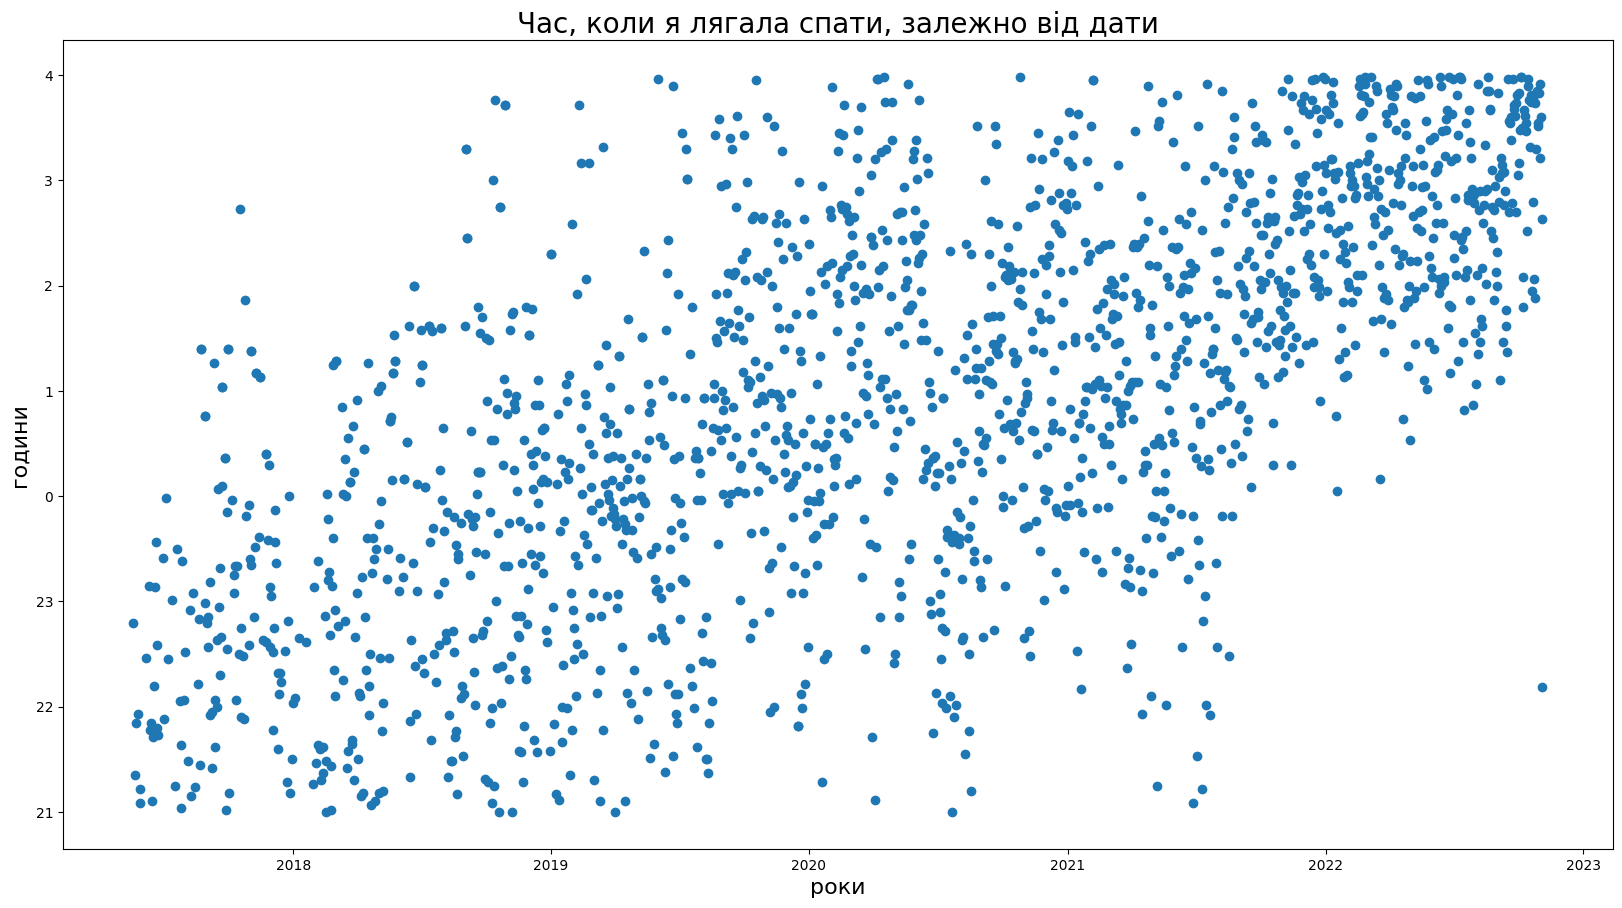

In [145]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10.5)
night_x = night_maxes
night_y = n
ax = plt.subplot()
ax.set_yticks([x for x in range(round(min(n)), round(max(n) + 1))])
ax.set_yticklabels(("21", "22","23","0","1","2","3","4"))

ax.set_xlabel('роки', fontsize=16)
ax.set_ylabel('години', fontsize=16)
ax.set_title('Час, коли я лягала спати, залежно від дати', fontsize=20)

ax.scatter(night_x, night_y)
plt.show()

Отже, в середньому я лягаю о 0:55, а встаю о 8:15

Чітко видно, що з роками я лягаю дедалі пізніше, а встаю дедалі раніше, що не є добре

<a id='sleep2'></a>

### У який час доби я пишу більше, а у який - менше?

In [168]:
dates_from_me = df.loc[df['from_id'] == my_id_str, 'date']
dates_to_me = df.loc[df['to_id'] == my_id, 'date']

dates_from_me = [dt.datetime.fromisoformat(timestamp).astimezone(timezone('Europe/Kyiv'))
             for timestamp in dates_from_me]
dates_to_me = [dt.datetime.fromisoformat(timestamp).astimezone(timezone('Europe/Kyiv'))
             for timestamp in dates_to_me]

In [169]:
def when_i_write(x, hours):
    hour = 0
    if x.minute > 30:
        hour = x.hour + 1
    else: hour = x.hour
        
    if hour in hours.keys():
        hours[hour] += 1
    else: hours[hour] = 1

In [170]:
hours_from_me = {}
hours_to_me = {}

for item in dates_from_me:
    when_i_write(item, hours_from_me)
    
for item in dates_to_me:
    when_i_write(item, hours_to_me)

hours_from_me = dict(sorted(hours_from_me.items(), key=lambda item : item[0]))
hours_to_me = dict(sorted(hours_to_me.items(), key=lambda item : item[0]))

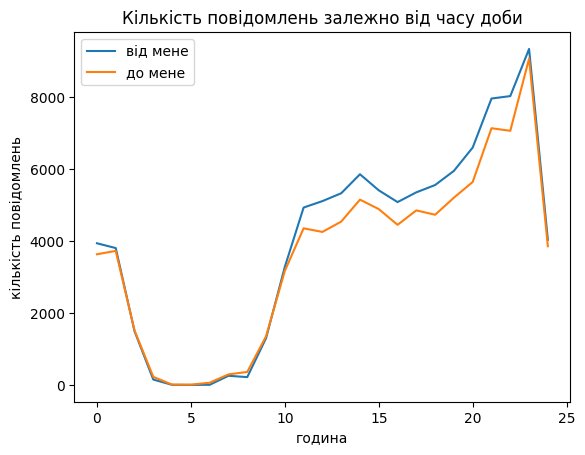

In [171]:
x_from_me = hours_from_me.keys()
y_from_me = hours_from_me.values()

x_to_me = hours_to_me.keys()
y_to_me = hours_to_me.values()

plt.plot(x_from_me,y_from_me)
plt.plot(x_to_me,y_to_me)
plt.legend(['від мене','до мене'])
plt.title('Кількість повідомлень залежно від часу доби')
plt.xlabel('година')
plt.ylabel('кількість повідомлень')
plt.show()

Таким чином, бачимо, що вночі з третьої до сьомої я майже не відправляю повідомлень, це період сну

А вночі, після двадцятої, активність починає збільшуватися

Значить для мене притаманно не спати вночі, але при цьому через навчання я прокидаюсь рано

<a id='gender'></a>

### З ким в мене більше листувань, небінарними людьми, дівчатами чи хлопцями?

Спочатку треба розмітити дані, ідентифікувати гендер тих, з ким у мене є переписка

In [173]:
genders = ('f', 'n', 'm')

In [142]:
df_meta_w_genders = df_meta.copy()

In [144]:
df_meta_w_genders['gender'] = [input(f'Гендер людини {df_meta_w_genders.at[num, "name"]}: ') 
                          if df_meta.loc[num, 'type'] == 'Private dialog' 
                          else None for num in range(len(df_meta_w_genders))]
# n - non-binary, f - female, m - male, None - bots and unknown

Гендер людини Rustam: m
Гендер людини Вікторія 🍇: f
Гендер людини Лариса: f
Гендер людини InfoSapiens: None
Гендер людини Katerina Nikolaieva: f
Гендер людини Trokhym Babych: m
Гендер людини Иван: m
Гендер людини nina: f
Гендер людини артем: m
Гендер людини Анна 🇺🇦: f
Гендер людини Масимка: m
Гендер людини Sergiy Kozerenko: m
Гендер людини Дайвинчик | Leomatchbot: None
Гендер людини StudSearch.org: None
Гендер людини Replies: None
Гендер людини Miléna: f
Гендер людини NaUKMA SAPS bot: None
Гендер людини Данило☀️: f
Гендер людини ДонорUA.Бот: None
Гендер людини Олексій: m
Гендер людини Вона за неї!: None
Гендер людини Denys Tsybulko: m
Гендер людини Marina Mor: f
Гендер людини keitbars: n
Гендер людини PenMates Bot: None
Гендер людини поля.: f
Гендер людини !йось: f
Гендер людини Таня: f
Гендер людини Віра: f
Гендер людини Nelli Blinova: f
Гендер людини Khrystyna Shmagola: f
Гендер людини 𝓐𝓷𝓪𝓼𝓽𝓪𝓼𝓲𝓪✨: f
Гендер людини Danylo: m
Гендер людини Ірина Л.: f
Гендер людини D. S.: f
Гендер людин

In [143]:
df_meta.loc[5623, 'gender'] = 'n'

In [155]:
df_meta_w_genders['gender'] = [None if df_meta_w_genders.loc[num, 'gender'] == 'None'
                               else df_meta_w_genders.loc[num, 'gender']
                               for num in range(len(df_meta_w_genders))]
df_meta = df_meta_w_genders

In [136]:
df_meta.to_csv('../data/merged_data/modified_dialogs_users_all.csv', index = False, encoding='utf-8') 

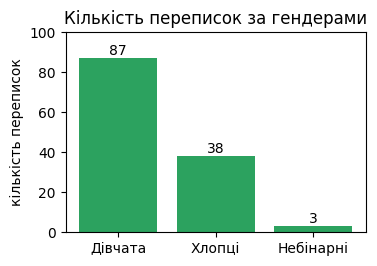

In [184]:
labels = {'f':'Дівчата', 'n':'Небінарні', 'm':'Хлопці'}

gender_amounts = {}
for gender in genders:
    gender_amounts[gender] = df_meta.loc[df_meta['gender'] == gender].shape[0]
gender_amounts = dict(sorted(gender_amounts.items(), key=lambda item: item[1], reverse=True))
    
x = [labels[gender] for gender in gender_amounts.keys()]
y = gender_amounts.values()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
fig.set_size_inches(3,2)

bar = ax.bar(x, y, color='#2ca25f')
ax.set_ylabel('кількість переписок')
ax.set_title('Кількість переписок за гендерами')

ax.bar_label(bar)
ax.set_ylim(top=100)

plt.show()

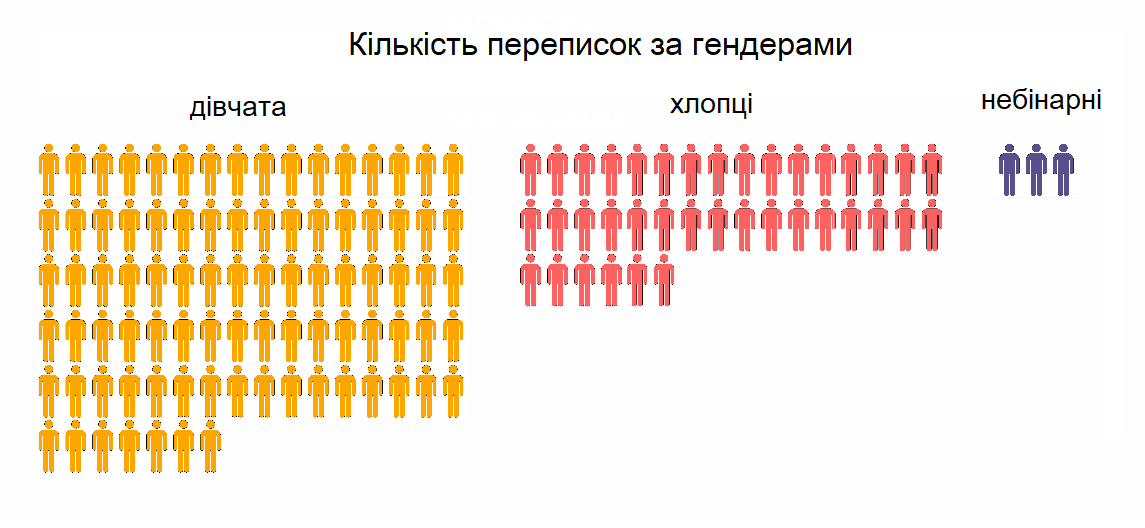

<a id='gender_date'></a>

### З ким за гендером в мене більше переписок у який період часу?

In [223]:
messages = {}

In [224]:
by_date = {}
for gender in genders:
    by_date[gender] = df.loc[df['gender'] == gender].copy()
    by_date[gender]['date'] = pd.to_datetime(by_date[gender]['date']).dt.date

In [225]:
messages = {}
for gender in genders:
    messages[gender] = dict(by_date[gender].groupby(['date'])['date'].count())

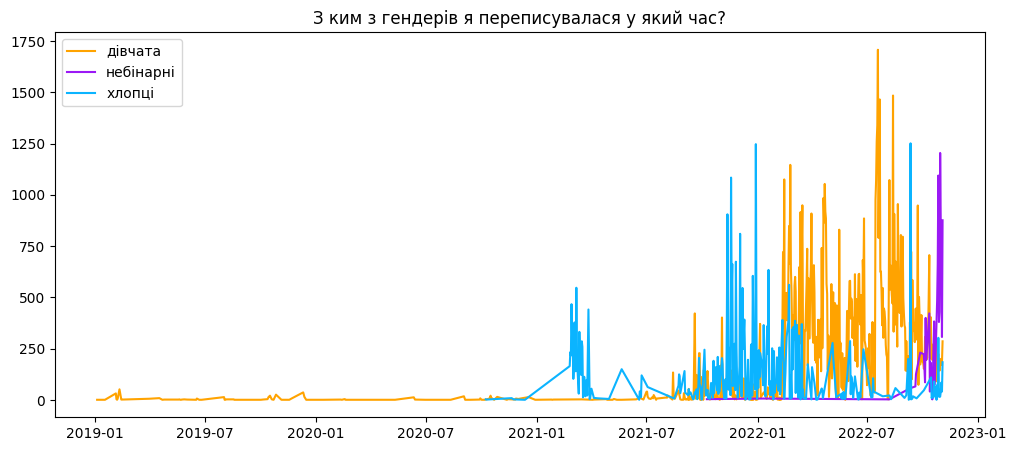

In [226]:
colors = ['#ffa300', '#9b19f5', '#0bb4ff', '#e60049']
fig = plt.subplots(figsize =(12,5))

counter = 0
labels = {'f':'дівчата','n':'небінарні','m':'хлопці'}
for gender in genders:
    plt.plot(get_x_y(messages[gender])[0], get_x_y(messages[gender])[1], label=labels[gender], \
          color=colors[counter])
    counter+=1
    
plt.legend()
plt.title('З ким з гендерів я переписувалася у який час?')
plt.show()

<a id='gender_date2'></a>

Згідно з даних отриманих пізніше [тут](#speaking) даних, велику частину на графіку визначає спілкування з Даною та Артемом

Погляньмо на графік після виключення цих двох переписок

In [227]:
by_date2 = {}
by_date2['f'] = by_date['f'].loc[df['dialog_id'] != ids['dana']].copy()
by_date2['m'] = by_date['m'].loc[df['dialog_id'] != ids['artem']].copy()

In [228]:
f_by_date2 = by_date2['f'][['date', 'gender']].copy()
m_by_date2 = by_date2['m'][['date', 'gender']].copy()

In [229]:
by_date2['f']['date'] = pd.to_datetime(by_date2['f']['date']).dt.date
by_date2['m']['date'] = pd.to_datetime(by_date2['m']['date']).dt.date

messages2 = {}
messages2['f'] = dict(by_date2['f'].groupby(['date'])['date'].count())
messages2['m'] = dict(by_date2['m'].groupby(['date'])['date'].count())
messages2['n'] = messages['n']

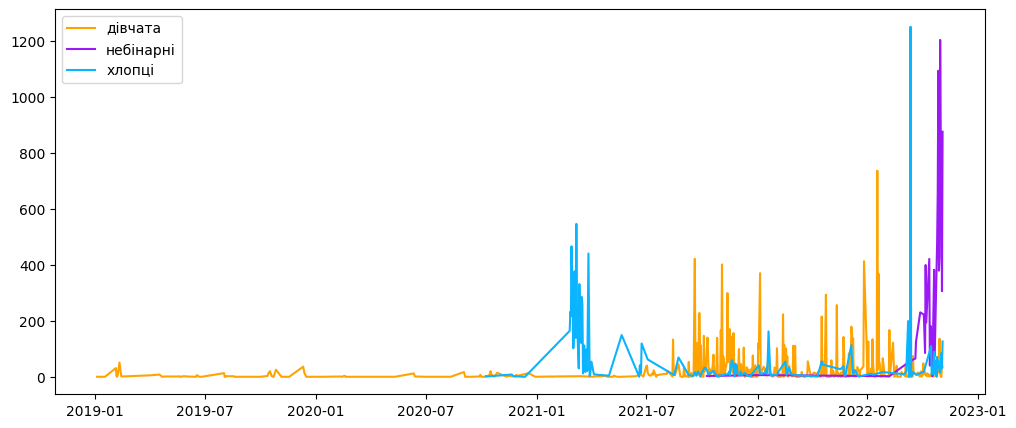

In [230]:
colors = ['#ffa300', '#9b19f5', '#0bb4ff', '#e60049']
fig = plt.subplots(figsize =(12,5))

counter = 0
labels = {'f':'дівчата','n':'небінарні','m':'хлопці'}
for gender in genders:
    plt.plot(get_x_y(messages2[gender])[0], get_x_y(messages2[gender])[1], label=labels[gender], \
          color=colors[counter])
    counter+=1

plt.legend()
plt.show()

Погляньмо детальніше на період від 2021 року

In [231]:
def cut_some_dates(x, y, date):
    new_dates = []
    for item in x:
        if item > date:
            new_dates.append(item)
            
    new_messages = y[len(x) - len(new_dates):len(x)]
    return new_dates, new_messages

In [234]:
new_x = {}
new_y = {}

for gender in genders:
    new_x[gender], new_y[gender] = \
                cut_some_dates(get_x_y(messages2[gender])[0], get_x_y(messages2[gender])[1],  dt.date(2021,1,1))

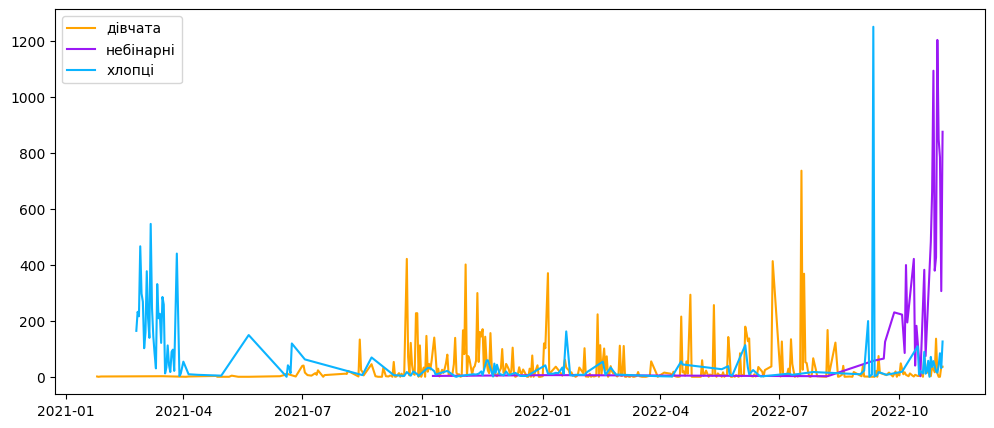

In [235]:
fig = plt.subplots(figsize =(12,5))

counter = 0
for gender in genders:
    plt.plot(new_x[gender], new_y[gender], label=labels[gender], color=colors[counter])
    counter += 1
    
plt.legend()
plt.show()

Отож, спілкування з дівчатами більш постійне та активне, ніж з хлопцями

Щодо небінарних людей, то тут можна бачити лише початок спілкування з однією людиною з осені 2022

<a id='language'></a>

### Якою мовою зазвичай листування?

In [ ]:
stanza.download(lang="multilingual")
stanza.download(lang="uk")
stanza.download(lang="en")
stanza.download(lang="de")
stanza.download(lang="ru")

In [ ]:
nlp = Pipeline(lang="multilingual", processors="langid", langid_lang_subset=['uk','en','de','ru'])

In [28]:
docs = df.loc[df['type'] == 'text', 'message']
docs = [Document([], text=text) for text in docs]
nlp(docs)
df.loc[df['type'] == 'text', 'lang'] = [doc.lang for doc in docs]

In [328]:
df.groupby('lang')['lang'].count()

lang
de     28323
en     20580
ru    252448
uk    553910
Name: lang, dtype: int64

In [148]:
langs = ['uk','en','de','ru']
labels = {'uk' : 'українська','en' : 'англійська','de' : 'німецька','ru' : 'російська'}

In [170]:
by_date = {}
for lang in langs:
    by_date[lang] = df.loc[(df['lang'] == lang) & (df['from_id'] == my_id_str)].copy()
    by_date[lang]['date'] = pd.to_datetime(by_date[lang]['date']).dt.date
    by_date[lang] = dict(by_date[lang].groupby(['date'])['date'].count())

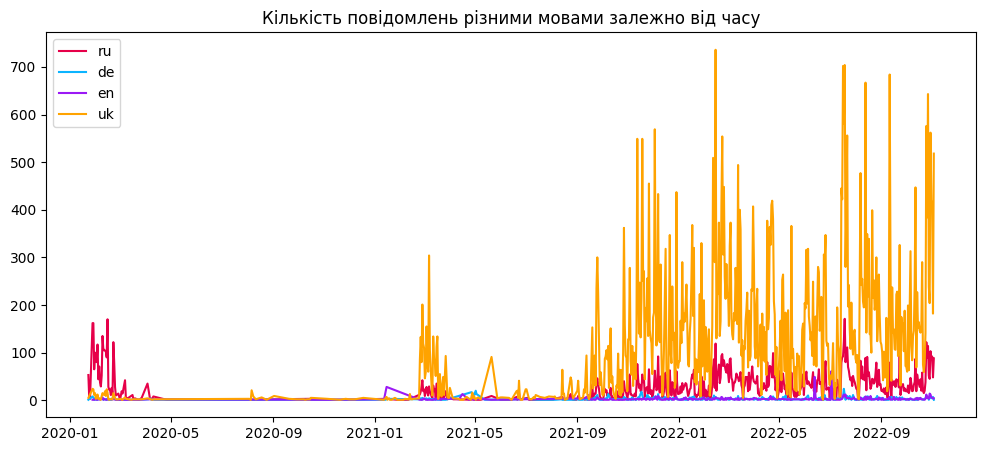

In [188]:
colors = ['#e60049','#0bb4ff','#9b19f5','#ffa300']
fig = plt.subplots(figsize =(12,5))

counter = 0
for lang in reversed(langs):
    plt.plot(get_x_y(by_date[lang])[0], get_x_y(by_date[lang])[1], label=lang, \
          color=colors[counter])
    counter += 1

plt.legend()
plt.title('Кількість повідомлень різними мовами залежно від часу')
plt.show()

In [191]:
def draw_plot(x, y, ax, color, title=None, fontsize=12):
    ax.scatter(x, y, color=color, s=7)
    
    ax.set_xlabel('дата', fontsize=fontsize/1.2)
    ax.set_ylabel('повідомлення', fontsize=fontsize/1.2)
    ax.set_xticks([dt.date(2020,1,1), dt.date(2021,1,1), dt.date(2022,1,1), dt.date(2023,1,1)])
    ax.set_xticklabels(("2020", "2021","2022","2023"))
    ax.set_title(title, fontsize=fontsize)

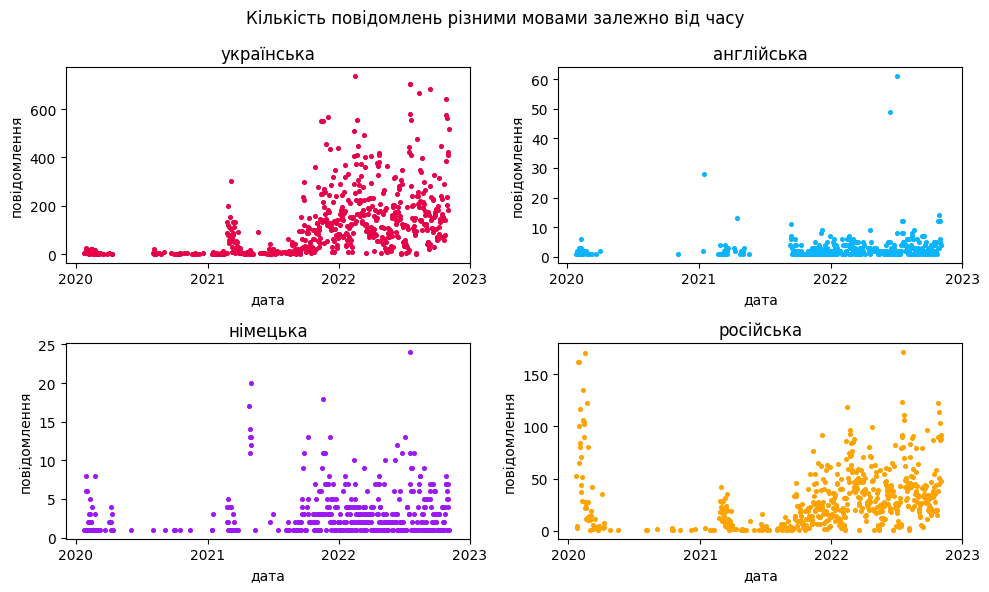

In [192]:
colors = ['#e60049','#0bb4ff','#9b19f5','#ffa300']
axes = [x for x in range(4)]
fig, ((axes[0], axes[1]), (axes[2], axes[3])) = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

counter = 0
for lang in langs:
    draw_plot(get_x_y(by_date[lang])[0], get_x_y(by_date[lang])[1], axes[counter],\
              title=labels[lang], color=colors[counter])
    counter += 1
    

plt.suptitle('Кількість повідомлень різними мовами залежно від часу')
plt.tight_layout()

Дуже багато повідомлень у переписках, які насправді не віднести ні до якої мови, проте алгоритм заніс їх до певних мов. Цим зумовлена похибка, наявна на графіках

Тобто, наприклад, до 2022 року я не писала нічого німецькою в телеграмі, проте на графіку можна побачити, що це не так

Тож з отриманих даних треба обережно робити висновки, і ось які зробила я: англійска майже відсутня, німецької стало більше, що було очікувваним, української стало більше, російської стало менше, проте все одно графік показує, що вона є, хоча я не пишу російською нічого зараз, можливо алгоритм зарахував слова, які пишуться однаково в українській та російській мовах до російської

<a id='who_writes_more'></a>

### Хто пише більше під час переписки, я чи людина, з якою я розмовляю?

За одну переписку умовно взято один день, оскільки важко визначити точно, які повідомлення стосуються однієі перписки, а які вже наледать до іншої, тому що між повідомленнями однієі розмови може бути від кількох хвилин до кількох годин

In [19]:
private = df.loc[df['dialog_type'] == 'Private dialog'].copy()

In [20]:
private['date'] = private['date'].apply(lambda x: dt.datetime.fromisoformat(x).astimezone(timezone('Europe/Kyiv')))

In [21]:
private = private.loc[(private['gender'] == 'f') | (private['gender'] == 'n') | (private['gender'] == 'm')]

In [22]:
private.rename(columns={'date': 'datetime'}, inplace=True)

private['date'] = private['datetime'].apply(lambda x: x.date())

In [23]:
dates = unique(list(private['date']))

In [ ]:
counter_me = 0
counter_others = 0

for date in dates:
    one_day = morning.loc[morning['date'] == date]
    ids = unique(list(one_day['dialog_id']))
    for id in ids:
        one_chat = one_day.loc[one_day['dialog_id'] == id]
        message = one_chat[one_chat['datetime'] == one_day['datetime'].min()].reset_index()
        if message.size > 0:
            from_id = message.loc[0, 'from_id']
            if from_id == my_id_str:
                counter_me += 1
            else: counter_others += 1

In [96]:
counter_me = counter_others = 0
chat_counter = 0

for date in dates:
    one_day = private.loc[(private['date'] == date)]
    ids = unique(list(one_day['dialog_id']))
    chat_counter += len(ids)
    for id in ids:
        one_chat = one_day.loc[one_day['dialog_id'] == id]
        from_me = one_day.loc[one_day['from_id'] == my_id_str]
        counter_me += from_me.shape[0]
        
        from_others = one_day.loc[one_day['from_id'] != my_id_str]
        counter_others += from_others.shape[0]
    
mean_me = counter_me / chat_counter
mean_others = counter_others / chat_counter

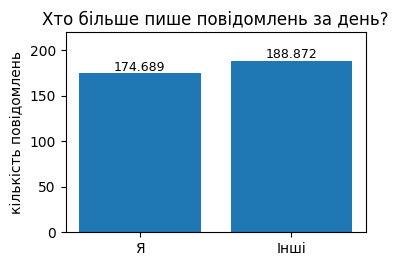

In [101]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
fig.set_size_inches(3,2)
x = ['Я', 'Інші']
y = [mean_me, mean_others]
bar = ax.bar(x,y)
plt.title("Хто більше пише повідомлень за день?")
plt.ylabel('кількість повідомлень')
ax.bar_label(bar, fontsize=9)
ax.set_ylim(top=220)
plt.show()

Бачимо, що суттєвої різниці немає, тобто у переписці я зі співрозмовником чи співрозмовницею пишемо однаково багато повідомлень

<a id='who_writes_first'></a>

### Хто частіше пише першою, я чи людина, з якою я розмовляю?

In [92]:
private['isMorning'] = private['datetime'].apply(lambda x: x.hour >= 4)
morning = private.loc[private['isMorning'] == True]

In [93]:
dates = unique([datetime for datetime in morning['date']])

In [102]:
counter_me = 0
counter_others = 0

for date in dates:
    one_day = morning.loc[morning['date'] == date]
    ids = unique(list(one_day['dialog_id']))
    for id in ids:
        one_chat = one_day.loc[one_day['dialog_id'] == id]
        message = one_chat[one_chat['datetime'] == one_day['datetime'].min()].reset_index()
        if message.size > 0:
            if message.loc[0, 'from_id'] == my_id_str:
                counter_me += 1
            else: counter_others += 1

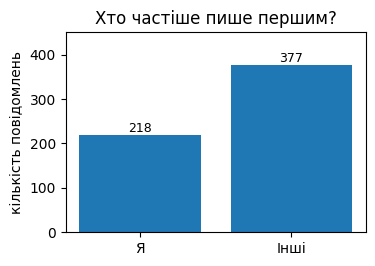

In [103]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
fig.set_size_inches(3,2)
x = ['Я', 'Інші']
y = [counter_me, counter_others]
bar = ax.bar(x,y)
plt.title("Хто частіше пише першим?")
plt.ylabel('кількість повідомлень')
ax.bar_label(bar, fontsize=9)
ax.set_ylim(top=450)
plt.show()

Отже, частіше пишуть мені, ніж пишу я

<a id='topics'></a>

### Які теми зазвичай у переписках?

Спочатку потрібно нормалізувати повідомлення

In [23]:
stopwords_ua = pd.read_csv(r"Ukrainian-Stopwords\stopwords_ua.txt", header=None, names=['stopwords'])
stop_words_ua = list(stopwords_ua.stopwords)

In [ ]:
stanza.download('uk')

In [ ]:
nlp = stanza.Pipeline('uk', processors='tokenize,mwt,pos,lemma,ner')

In [253]:
def get_lemmas(text):
    doc = nlp(text)
    lemmas = [word.lemma for sent in doc.sentences for word in sent.words if word.lemma not in stop_words_ua 
            if word.lemma not in string.punctuation]
    return lemmas

In [78]:
all_private_ids = list(df_meta.loc[(df_meta['type'] == 'Private dialog')\
                      & ((df_meta['gender'] == 'f') | (df_meta['gender'] == 'n') | (df_meta['gender'] == 'm')),\
                                   'dialog_id'])
all_private_ids.remove(1111925023)

In [254]:
def get_normalized_messages(name):
    try:
        id = get_id(name)
        messages_df = get_messages(id)['message']
        normalized_messages = []
        for message in messages_df:
            lemmas = get_lemmas(message)
            normalized_message = ' '.join(lemmas)
            normalized_messages.append(normalized_message)
        return normalized_messages
    except Exception as e:
        print("ERROR : "+str(e))

In [2]:
normalized_messages = {}

In [ ]:
for id in all_private_ids:
    if id not in ids.values() and get_messages(id).shape[0] > 20:
        name = df_meta.loc[df_meta['dialog_id'] == id].reset_index().loc[0,'name']
        normalized_messages[name] = get_normalized_messages(id)
normalized_messages['polina'] = get_normalized_messages(ids['polina'])
normalized_messages['ptashka'] = get_normalized_messages(ids['ptashka'])

Записую нормалізовані повідомлення у файли, щоб не витрачати зоразу час на завантаження

In [29]:
for id in all_private_ids:
    if id not in ids.values() and get_messages(id).shape[0] > 20:
        name = df_meta.loc[df_meta['dialog_id'] == id].reset_index().loc[0,'name']
        with open(f'normalized_messages/{name}_messages.txt', 'w') as f:
            f.write(json.dumps(normalized_messages[name]))
            
with open(f'normalized_messages/ptashka_messages.txt', 'w') as f:
    f.write(json.dumps(normalized_messages['ptashka']))
with open(f'normalized_messages/polina_messages.txt', 'w') as f:
    f.write(json.dumps(normalized_messages['polina']))

Завантажую з файлів листування

In [357]:
for id in all_private_ids:
    if id not in ids.values() and get_messages(id).shape[0] > 20:
        name = df_meta.loc[df_meta['dialog_id'] == id].reset_index().loc[0,'name']
        with open(f'normalized_messages/{name}_messages.txt', 'r') as f:
            normalized_messages[name] = json.loads(f.read())

with open(f'normalized_messages/ptashka_messages.txt', 'r') as f:
    normalized_messages['ptashka'] = json.loads(f.read())
with open(f'normalized_messages/polina_messages.txt', 'r') as f:
    normalized_messages['polina'] = json.loads(f.read())

Додаю отримані дані (нормалізовані повідомлення) у головну таблицю

In [ ]:
for id in all_private_ids:
    if id not in ids.values() and get_messages(id).shape[0] > 20:
        name = df_meta.loc[df_meta['dialog_id'] == id].reset_index().loc[0,'name']
        df.loc[(df['dialog_name'] == name) & (df['type'] == 'text'), 'normalized']\
        = normalized_messages[name]
        
df.loc[(df['dialog_name'] == 'Поліна') & (df['type'] == 'text'), 'normalized']\
        = normalized_messages['polina']
df.loc[(df['dialog_name'].str.contains('^Анна ', regex=True)) & (df['type'] == 'text'), 'normalized']\
        = normalized_messages['ptashka']

In [368]:
vectorizer = TfidfVectorizer()
vec_matrix = vectorizer.fit_transform(df.loc[df['normalized'] == df['normalized'], 'normalized'])

In [369]:
print(vec_matrix.shape)
terms = vectorizer.get_feature_names()

(25325, 14457)


C:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [374]:
n_clusters = 100

km = KMeans(n_clusters=n_clusters)
km.fit(vec_matrix)

KMeans(n_clusters=100)

In [ ]:
clusters = km.labels_.tolist()
df.loc[df['normalized'] == df['normalized'], 'cluster'] = clusters

In [376]:
print("Топ слова у кластері:")
print()

order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(n_clusters):
    print(f'Кластер {i} слова:', end='')
    
    for ind in order_centroids[i, :6]:
        print(f' {terms[ind]}', end=',')
        
    print() 
    print() 
    
    print(f'Кластер {i} назви:' )
    print(str(len(df.loc[df['cluster'] == i]['message'].values.tolist())) + ' - всього')
    print()
    
print()
print()

Топ слова у кластері:

Кластер 0 слова: загалом, норма, знати, інформація, конкретно, спілкуватися,

Кластер 0 назви:
55 - всього

Кластер 1 слова: нє, правда, відповісти, повертати, гарячий, діскорд,

Кластер 1 назви:
60 - всього

Кластер 2 слова: казати, дивитися, норма, знати, подобатися, бачити,

Кластер 2 назви:
17794 - всього

Кластер 3 слова: нормально, викладачка, нуути, виступити, уявити, секунда,

Кластер 3 назви:
35 - всього

Кластер 4 слова: nan, سمی, грудень, груша, грустно, группа,

Кластер 4 назви:
619 - всього

Кластер 5 слова: знати, правильно, розказати, нууу, планувати, штук,

Кластер 5 назви:
300 - всього

Кластер 6 слова: факт, відповісти, привіт, констатувати, констатація, фан,

Кластер 6 назви:
45 - всього

Кластер 7 слова: принцип, логічно, нуу, можливо, різниця, тютюн,

Кластер 7 назви:
34 - всього

Кластер 8 слова: жити, гурто, кімната, місто, щасливо, тип,

Кластер 8 назви:
102 - всього

Кластер 9 слова: думати, правильно, знати, дивитися, приємно, писати,

К

Проаналізувавши створені кластери я виділила декілька тем

*Можна побачити достатньо багато кластерів пов'язаних з навчанням: це і про семінари, екзамени, колоквіуми, і про лекції, які є в записі, і про вибір факультету, спеціальності та вибіркових дисциплін, і про багато іншого*

- Кластер 37 слова: немати, запис, сенс, зв, язок, лекція,
- Кластер 32 слова: удач, семінар, колоквіум, змагання, пара, пліз,
- Кластер 85 слова: спеціальність, відмінність, факультет, курс, соня, різний,
- Кластер 77 слова: англійський, взагалі, пара, матеріал, читати, програмування,
- Кластер 72 слова: вибір, вільний, немати, слухати, проблема, задоволений,
- Кластер 99 слова: вимога, дані, кредит, наказ, гуманітарний, читати,
- Кластер 71 слова: примат, вивчати, хлопець, любити, програмування, факультет,
- Кластер 33 слова: відповідь, отримати, питання, знати, скинути, думати,

*Також часто у листуванні ми питаємо одне одного, чи зручно слухати голосові, зідзвонитися, або попереджаємо, що зникнемо на певний час з мережі*

- Кластер 21 слова: голосовий, слухати, записувати, зручно, записати, взагалі,
- Кластер 23 слова: хвилина, 40, 10, зникнути, 15, 20,

*Частою є тема курсів німецької, на які я нині ходжу і про які, відповідно, розказую іншим*

- Кластер 58 слова: курс, німецький, привіт, ютерний, комп, взагалі,

*Тема війни та необхідності виїжджати з окупованих територій за можливості*

- Кластер 27 слова: виїжджати, важко, вбити, приблизно, окупований, логічно,

*Кластер про життя в гурто і про те, як це було класно*

- Кластер 8 слова: жити, гурто, кімната, місто, щасливо, тип,

*Опитування людей, чи роблять вони кутю і якщо так, то з якими інгредієнтами*

- Кластер 29 слова: робити, знати, куть, різдво, привіт, дз,

*Кластер про стосунки*

- Кластер 64 слова: зустрічатися, дівчина, цисгендерний, асексуальний, бібліотека, очевидно,

<a id='friends'></a>

## Аналіз переписок з друзями

Я обрала для аналізу 4 переписки з друзями чи близькими людьми

Записую їхні id, оскільки вони знадобляться пізніше

In [245]:
ids = {}

ids['artem'], ids['ptashka'] = get_id('^Артем'), get_id('^Анна')
ids['polina'] = int(df_meta.loc[df_meta['name'].str.contains('^Поліна', regex=True)].loc[5741, 'dialog_id'])
ids['dana'] = int(df_meta.loc[df_meta['name'].str.contains('^Данило', regex=True)].loc[5751, 'dialog_id'])

In [272]:
names = ['dana', 'ptashka', 'polina', 'artem']

In [273]:
labels = {'dana':'Дана', 'ptashka':'Пташка', 'polina':'Поліна', 'artem':'Артем'}

<a id='words'></a>

### Які найбільш використовувані слова в листуванні?

Спочатку робимо з усіх повідомлень один рядок

In [257]:
# у функцію можна передавати як нікнейм або його частину, використовуючи regular expressions, так і id діалогу
def word_frequencies(name):
    try:
        id = get_id(name)
        messages_df = get_messages(id)
        text = ' '.join(messages_df['message'])
        lemmas = get_lemmas(text)
        fdist = FreqDist(lemmas)
        sorted_fdist = sorted(fdist.items(), key=lambda x:x[1], reverse=True)
        return sorted_fdist
    except Exception as e:
        print("ERROR : "+str(e))

In [312]:
fdists = {}
for name in names:
    fdists[name] = word_frequencies(ids[name])

Записуємо ці дані про переписки у файли, щоб потім можна було легко їх отримати, не чекаючи нової обробки повідомлень

In [97]:
for name in names:
    with open(f'fdists/{name}_fdist.txt', 'w') as f:
        f.write(json.dumps(fdists[name])) 

In [261]:
fdists = {}
for name in names:
    with open(f'fdists/{name}_fdist.txt', 'r') as f:
        fdists[name] = json.loads(f.read())     

In [262]:
def words(fdist):
    return [i[0] for i in fdist]

def numbers(fdist):
    return [i[1] for i in fdist]

In [263]:
fdist_words = {}
fdist_numbers = {}

In [264]:
for name in names:
    fdist_words[name] = words(fdists[name])
    fdist_numbers[name] = numbers(fdists[name])

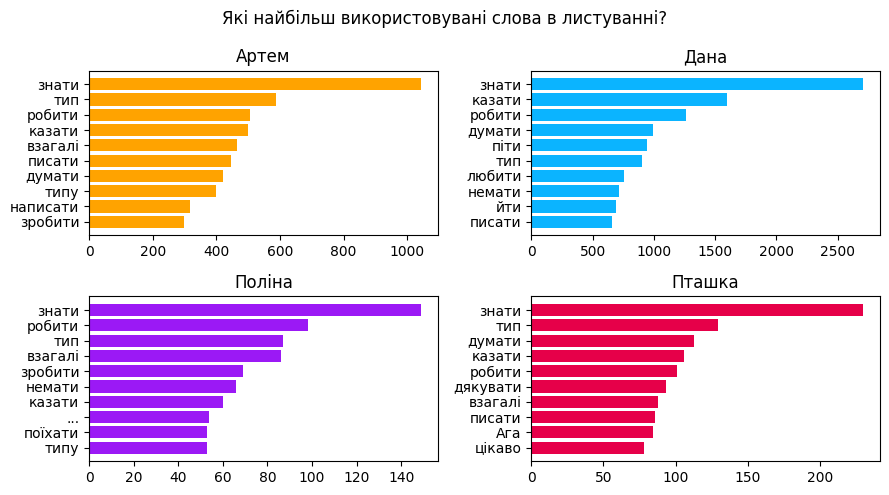

In [271]:
fig, axs = plt.subplots(2, 2, figsize=(9,5))
n = 10 # перші n слів будуть показані на графіку

colors = ['#ffa300', '#0bb4ff','#9b19f5', '#e60049']
axes = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]
counter = 0
for name in names:
    axes[counter].barh(fdist_words[name][0:n][::-1],fdist_numbers[name][0:n][::-1], color=colors[counter])
    axes[counter].set_title(labels[name])
    counter += 1
    
plt.suptitle('Які найбільш використовувані слова в листуванні?')
fig.tight_layout()

Можна побачити багато спільних у цих чотирьох переписках

Це свідчить про те, що це нейтральні слова, які часто трапляються в різних розмовах

Неочевидною була висока вживаність слова 'взагалі'

<a id='bigrams'></a>

### А якими є найбільш використовувані пари слів?

In [257]:
messages = {}

for name in names:
    messages[name] = get_messages(ids[name])

In [252]:
def ngrams(messages):
    c_vec = CountVectorizer(ngram_range=(2,2))
    ngrams = c_vec.fit_transform(messages)
    count_values = ngrams.toarray().sum(axis=0)
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
                           ).rename(columns={0: 'frequency', 1:'bigram'})
    return df_ngram

In [253]:
bigrams = {}

for name in names:
    bigrams[name] = ngrams((messages[name]['message'].values.astype('U')))

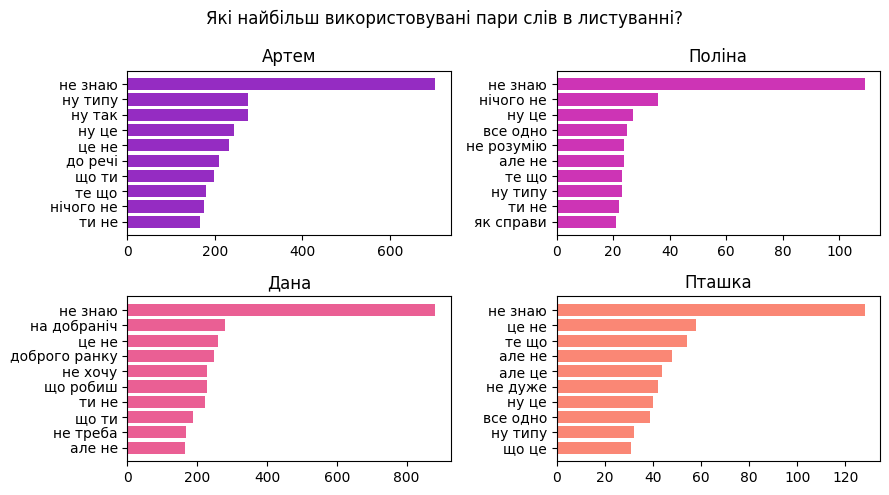

In [85]:
fig, axs = plt.subplots(2, 2, figsize=(9,5))
n = 10

colors = ['#952CC2', '#CD34B5', '#EA5F94', '#FA8775']
axes = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]
counter = 0
for name in names:
    axes[counter].barh(bigrams[name][0:n][::-1],bigrams[name][0:n][::-1], color=colors[counter])
    axes[counter].set_title(labels[name])
    counter += 1

plt.suptitle('Які найбільш використовувані пари слів в листуванні?')
fig.tight_layout()

In [260]:
def get_bigrams(bigrams_fdist, words):
    return [int(bigrams_fdist.loc[bigrams_fdist['bigram'] == word]['frequency']) for word in words]

In [261]:
words = ['не знаю', 'ну типу', 'все одно']

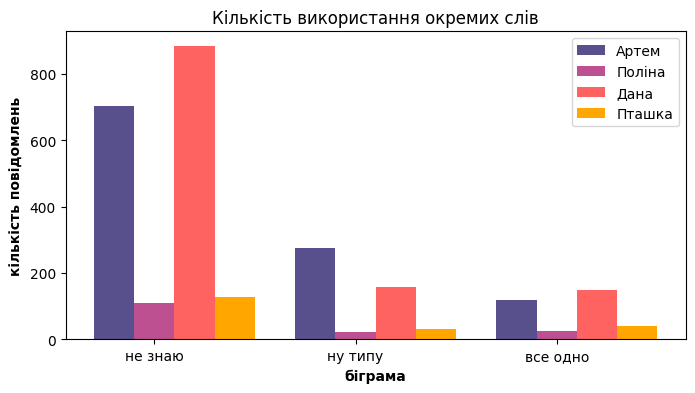

In [37]:
barWidth = 0.2
fig = plt.subplots(figsize =(8, 4))

brs = []
brs.append(np.arange(len(words_to_find)))
for i in range(1,4):
    brs.append([x + barWidth for x in brs[i-1]])
    
colors = ['#58508d', '#bc5090', '#ff6361', '#ffa600']
names = ['artem', 'polina', 'dana', 'ptashka']

for i in range(4):
    plt.bar(brs[i], get_bigrams(bigrams[names[i]], words), width = barWidth,
            color=colors[i], label =labels[names[i]])

plt.xlabel('біграма', fontweight ='bold', fontsize = 10)
plt.ylabel('кількість повідомлень', fontweight ='bold', fontsize = 10)
plt.xticks([r + barWidth for r in range(len(words))],
['не знаю', 'ну типу', 'все одно'])

plt.title('Кількість використання окремих слів')
plt.legend()
plt.show()

Можна зробити припущення, що кількість цих слів пропоційна загальній кількості повідомлень, можна це перевірити

In [39]:
proportion = {}

for name in names:
    proportion[name] = [x/get_messages(ids[name]).shape[0] for x in get_bigrams(bigrams[name], words)]

In [43]:
names = ['artem', 'polina', 'ptashka', 'dana']
for name in names:
    print(proportion[name][0])

0.02576961089351733
0.024795268425841673
0.014702504020215943
0.009314345991561182


In [45]:
names = ['polina', 'artem', 'ptashka', 'dana']
x = [get_messages(ids[name]).shape[0] for name in names]
y = [get_bigrams(bigrams[name], words) for name in names]

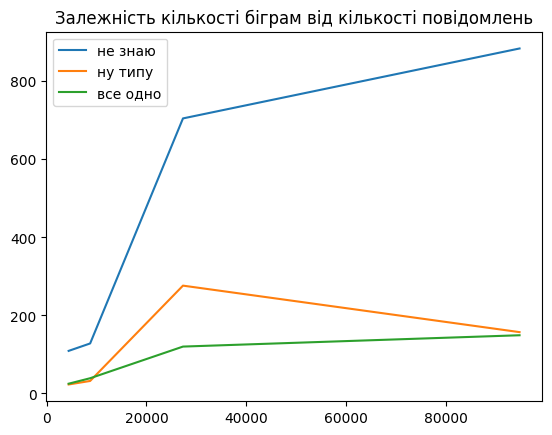

In [47]:
plt.plot(x,y)
plt.legend(['не знаю','ну типу', 'все одно'])
plt.title('Залежність кількості біграм від кількості повідомлень')
plt.show()

Можна сказати, що все ж кількість найпопулярніших біграм не є прямо пропорційною до кількості повідомлень

<a id='studying'></a>

### Частота використання слів, пов'язаних із навчанням

In [276]:
def find_words(fdist, words):
    try:
        return [dict(fdist)[word] if word in dict(fdist) else 0 for word in words]
    except Exception as e:
        print("ERROR : "+str(e))

In [312]:
def find_words_in_chats(words_to_find):    
    barWidth = 0.2
    fig = plt.subplots(figsize =(8, 4))

    brs = []
    brs.append(np.arange(len(words_to_find)))
    for i in range(1,4):
        brs.append([x + barWidth for x in brs[i-1]])
    
    colors = ['#58508d', '#bc5090', '#ff6361', '#ffa600']
    names = ['artem', 'polina', 'dana', 'ptashka']

    for i in range(4):
        plt.bar(brs[i], find_words(fdists[names[i]], words_to_find), width = barWidth,
            color =colors[i], label =labels[names[i]])

    plt.xlabel('слово', fontweight ='bold', fontsize = 10)
    plt.ylabel('кількість повідомлень', fontweight ='bold', fontsize = 10)
    plt.xticks([r + barWidth for r in range(len(words_to_find))], words_to_find)

    title = f"Використання слів "
    for i in range(len(words_to_find) - 1):
        title += f"'{words_to_find[i]}', "
    title += f"'{words_to_find[-1]}'"
    
    plt.title(title)
    plt.legend()
    plt.show()

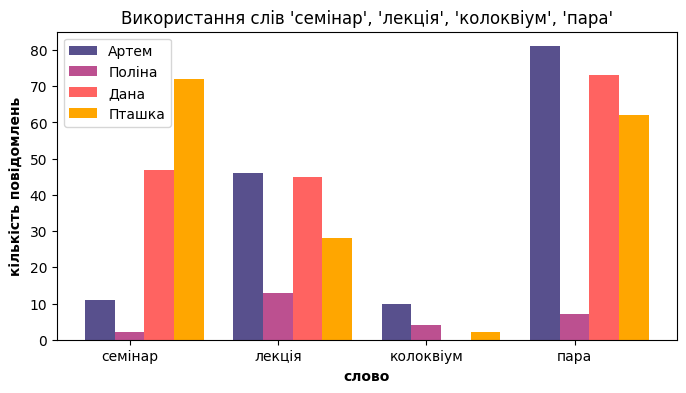

In [315]:
find_words_in_chats(['семінар', 'лекція', 'колоквіум', 'пара'])

<a id='pos_and_neg'></a>

### Частота використання позитивно- та негатовнозабарвлених емоційних слів

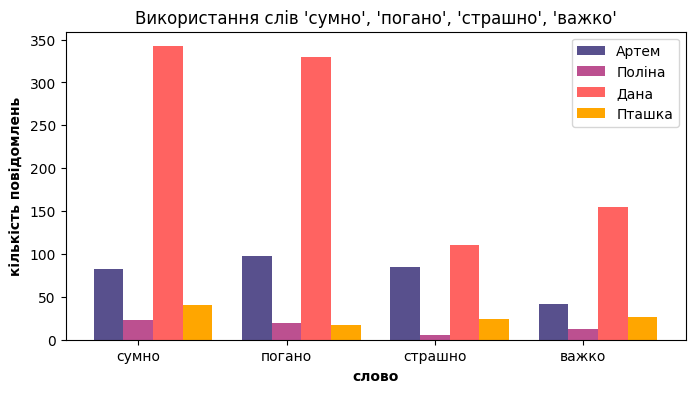

In [316]:
find_words_in_chats(['сумно', 'погано', 'страшно', 'важко'])

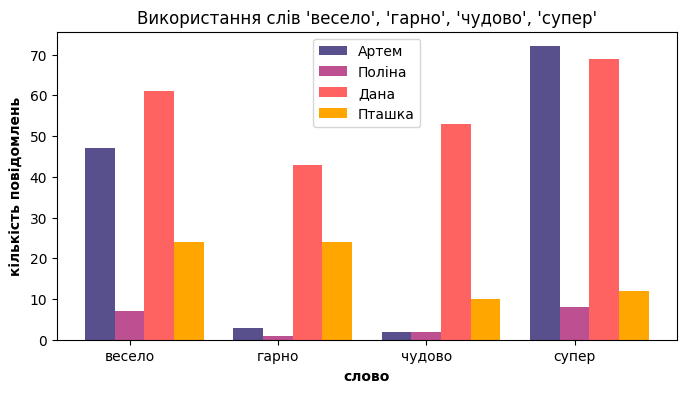

In [296]:
find_words_in_chats(['весело', 'гарно', 'чудово', 'супер'])

<a id='naukma'></a>

### Частота використання слів, пов'язаних зі студентстьким життям

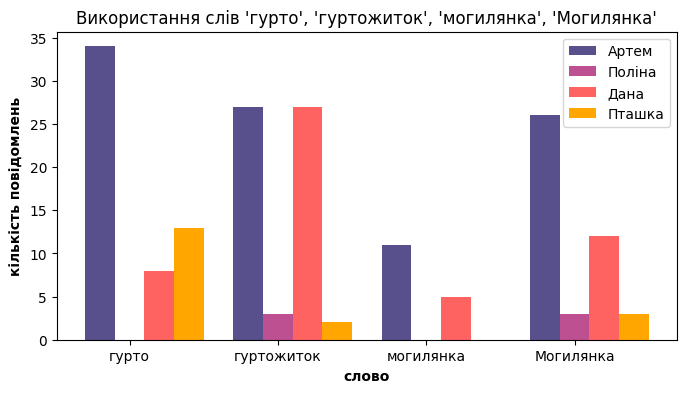

In [297]:
find_words_in_chats(['гурто', 'гуртожиток', 'могилянка', 'Могилянка'])

<a id='war'></a>

### Частота використання слів, пов'язаних із виїздом з окупованих територій

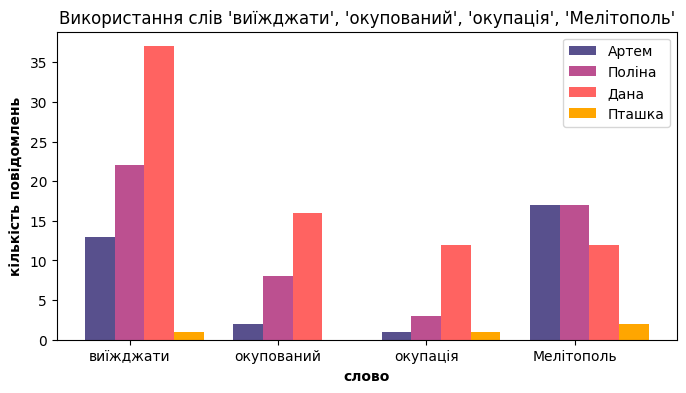

In [298]:
find_words_in_chats(['виїжджати', 'окупований', 'окупація', 'Мелітополь'])

<a id='emojis'></a>

### Погляньмо на найбільш використовувані смайлики

In [320]:
def get_emojis(fdist_words):
    emojis = [word if word in emoji.EMOJI_DATA else None for word in fdist_words]
    emojis = list(dict.fromkeys(emojis)) # видаляємо елементи зі значенням None
    return emojis

In [321]:
names = ['dana', 'ptashka', 'polina', 'artem']

In [322]:
emojis = {}
for name in names:
    emojis[name] = get_emojis(fdist_words[name])[1:]

In [323]:
for name, value in emojis.items():
    print(name, len(value))

dana 184
ptashka 49
polina 49
artem 104


In [327]:
num = 5
for name in names:
    print(labels[name])
    print(emojis[name][0:num])

Дана
['❤️', '🥺', '❤', '🌚', '😚']
Пташка
['🤔', '🥺', '🌚', '🙃', '✨']
Поліна
['🌚', '🤔', '♀', '😢', '👍']
Артем
['🙃', '🤨', '🤔', '😅', '🤷\u200d♂']


Можемо бачити, що емоджі різні в усіх чатах, відповідно, якісь переписки більш позитивні чи милі, якісь - навпаки

<a id='emojis2'></a>

### Які смайликі трапляються в усіх 4 чатах?

In [316]:
sets = {}

for name in names:
    sets[name] = set(x[0] for x in fdists[name])

common_words = []
for name in sets['ptashka'].intersection(sets['artem']).intersection(sets['polina']).intersection(sets['dana']):
    common_words.append(name)
    
common_words

['погано',
 'формат',
 'зовнішній',
 'сучасний',
 'відповісти',
 'початися',
 'цікавий',
 'сезон',
 'камера',
 'рекомендувати',
 'інформація',
 'скинути',
 'закордон',
 'позиція',
 'набриднути',
 'вирішити',
 'хотітися',
 'гарний',
 'потягти',
 'перехід',
 'нормально',
 'змінювати',
 'щасливий',
 'переконувати',
 'удач',
 'nan',
 'право',
 'розуміння',
 'світ',
 'вдома',
 'Київ',
 'залежати',
 'норма',
 'приїхати',
 'столиця',
 'приходити',
 '))',
 'відкривати',
 'заходити',
 'множина',
 'знати',
 'прийти',
 'тест',
 'ігровий',
 '...',
 'проходити',
 'придумати',
 'аа',
 'Ладно',
 'вибух',
 'користуватися',
 'кидати',
 'здоров’я',
 'подарунок',
 'жовтень',
 'зустріти',
 'закінчувати',
 'віддавати',
 'більший',
 'зворотний',
 'встигти',
 'закінчення',
 'довжина',
 'ліс',
 'швидко',
 'розмовляти',
 'весело',
 'мітинг',
 '👌',
 'місяць',
 'частина',
 'оооо',
 'ші',
 'гра',
 'виділятися',
 'думати',
 'Сорі',
 'смачний',
 'страшно',
 'книжка',
 'використовувати',
 'теорія',
 'вдячний',
 'шан

Нижче наведені смайлики, спільні для всіх 4 переписок

In [112]:
for word in common_words:
    if word in emoji.EMOJI_DATA:
        print(word)
    else: print('', end=' ')

              🤔
                                                   🥰
                                  🤨
                                                                                   🥲
  🌚
                                                                                               🤡
                                                                                                                                                                                                                               👍
                                                      😢
                                                                    😡
                                                            😐
 🙃
                              ✋
                                                                           🙄
           😎
                                  😞
                                                                   👌
                                          🤷‍♀
                    

Серед них є як позитивні, так і негативні чи нейтральні, вони показують звичні для листування емоції

<a id='emojis3'></a>

### Яких смайликів більше: позитивних чи негативних?

In [ ]:
all_emojis = []
for name in names:
    all_emojis.extend(emojis[name])

In [165]:
all_emojis = unique(all_emojis)

Робимо розмітку даних, даємо кожному емоджі значення емоційної забарвленості

In [177]:
emoji_sensitivity = []

def set_sensitivity(emojis):
    return [int(input(f'Емоційне забарвлення смайлика {emojis[num]}: ')) if emojis[num] not in emoji_sensitivity
            else None for num in range(len(emojis))]

# 1 - positive, -1 - negative, 0 - neutral

In [181]:
emoji_sensitivity = set_sensitivity(all_emojis)

Емоційне забарвлення смайлика ‼️: 0
Емоційне забарвлення смайлика ▪: 0
Емоційне забарвлення смайлика ▶: 0
Емоційне забарвлення смайлика ☀: 1
Емоційне забарвлення смайлика ☀️: 1
Емоційне забарвлення смайлика ☝: 1
Емоційне забарвлення смайлика ☝️: 1
Емоційне забарвлення смайлика ☠: 0
Емоційне забарвлення смайлика ☹: -1
Емоційне забарвлення смайлика ☹️: -1
Емоційне забарвлення смайлика ☺: 1
Емоційне забарвлення смайлика ☺️: 1
Емоційне забарвлення смайлика ♀: 0
Емоційне забарвлення смайлика ♥: 1
Емоційне забарвлення смайлика ♥️: 1
Емоційне забарвлення смайлика ⚡: 1
Емоційне забарвлення смайлика ✅: 1
Емоційне забарвлення смайлика ✊: 1
Емоційне забарвлення смайлика ✋: 1
Емоційне забарвлення смайлика ✌: 1
Емоційне забарвлення смайлика ✌️: 1
Емоційне забарвлення смайлика ✨: 1
Емоційне забарвлення смайлика ❄️: 1
Емоційне забарвлення смайлика ❕: 0
Емоційне забарвлення смайлика ❗: 0
Емоційне забарвлення смайлика ❣: 1
Емоційне забарвлення смайлика ❣️: 1
Емоційне забарвлення смайлика ❤: 1
Емоційне 

Емоційне забарвлення смайлика 🫰: 1
Емоційне забарвлення смайлика 🫶: 1


In [183]:
emojis_with_sense = dict(zip(all_emojis, emoji_sensitivity))

In [188]:
with open('emojis_with_sensitivity.txt', 'w') as file:
     file.write(json.dumps(emojis_with_sense))

In [378]:
with open('emojis_with_sensitivity.txt', 'r') as f:
    emojis_with_sense = json.loads(f.read())

In [376]:
# емоція одного рядка
def get_emotions(phrase):
    emotions_sum = 0
    for char in phrase:
        if char in emojis_with_sense.keys():
            emotions_sum +=  emojis_with_sense[char]
    return emotions_sum

In [374]:
def chat_sensitivity(name):
    emotions_pos = 0
    emotions_neg = 0
    emotions_prop = 0
    for item in fdists[name]:
        x = get_emotions(item[0])
        if x > 0: emotions_pos += x
        else: emotions_neg += x
    if emotions_neg == 0: emotions_prop = emotions_pos/1
    else: emotions_prop = emotions_pos / (emotions_pos + abs(emotions_neg))

    return emotions_prop

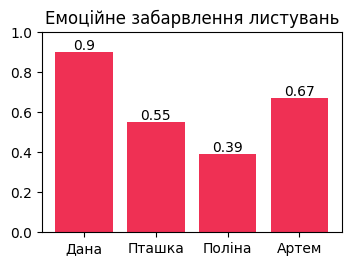

In [384]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
fig.set_size_inches(3,2)
x = ['Дана', 'Пташка', 'Поліна', 'Артем']
y = [round(chat_sensitivity(name) ,2) for name in names]
bar = ax.bar(x, y, color='#ef3054')
ax.set_ylim(top=1)
plt.title("Емоційне забарвлення листувань")
ax.bar_label(bar)

plt.show()

<a id='emojis_sentiment'></a>

Отже, переписка з Даною найбільш емоційна й забарвлена позитивно

При цьому, найбільш негативною є переписка з Поліною

<a id='sentiment'></a>

### Сентиментальний аналіз

Завантажуємо тональний словник української мови

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

In [68]:
url = 'https://raw.githubusercontent.com/lang-uk/tone-dict-uk/master/tone-dict-uk.tsv'
r = requests.get(url)
with open('tone-dict-uk.tsv', 'wb') as f:
    f.write(r.content)

In [71]:
d ={}
with open('tone-dict-uk.txt', 'r', encoding = 'UTF-8') as csv_file:
    for row in csv.reader(csv_file, delimiter='\n'):
        word = row[0].split('\t')
        d[word[0]] = float(word[1])
SIA = SentimentIntensityAnalyzer()
SIA.lexicon.update(d)

In [92]:
def sent_analysis(id):
    mean = 0
    length = len(df.loc[(df['dialog_id'] == id) & (df['type'] == 'text'), 'normalized'])

    for message in df.loc[(df['dialog_id'] == id) & (df['type'] == 'text'), 'normalized']:
        mean += SIA.polarity_scores(str(message))["compound"]

    mean /= length
    return mean

In [133]:
sense_dict = {}

for id in all_private_ids:
    sense_num = sent_analysis(id)
    name = df.loc[df['dialog_id'] == id].reset_index().loc[0,'dialog_name']
    if sense_num != 0: sense_dict[name] = sense_num

In [136]:
lenghts = []
for name in sense_dict.keys():
    lenghts.append(len(df.loc[(df['dialog_name'] == name) & (df['type'] == 'text'), 'normalized']))

lenghts.sort()

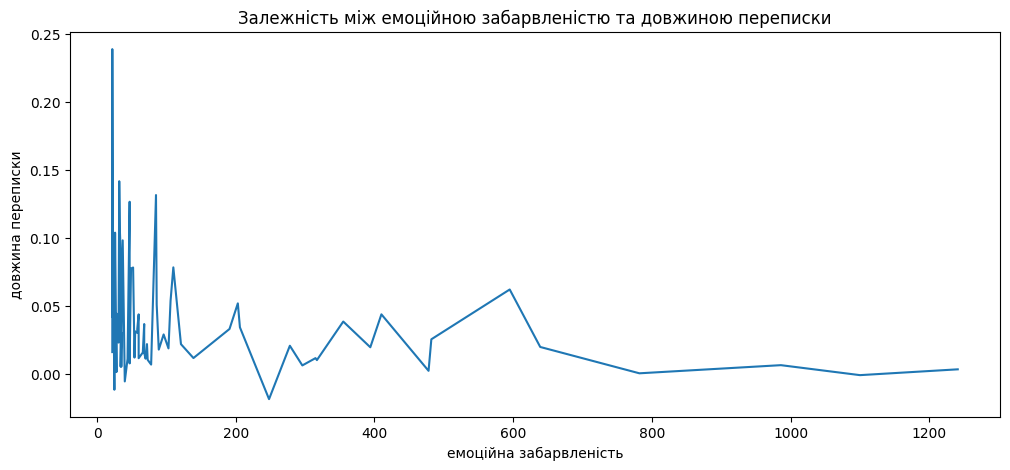

In [146]:
fig = plt.subplots(figsize =(12,5))
plt.title('Залежність між емоційною забарвленістю та довжиною переписки')
plt.xlabel('емоційна забарвленість')
plt.ylabel('довжина переписки')
plt.plot(lenghts, sense_dict.values())
plt.show()

Отже, чим більше повідомлень у переписці, тим менш позитивною вона є

Це можна пояснити тим, що якщо переписка довга, то вона, ймовірно, з кимось більш близьким, з ким ми ділимося як позитивними емоціями, так і негативними, наприклад, з друзями, одногрупниками і так далі

А якщо переписка коротка, то більш ймовірно, що вона була з не дуже знайомою людиною, тож відповідно менше розмов про щось негативне

<a id='speaking'></a>

[Повернутися назад до питання про спілкування з людьми різних гендерів](#gender_date2)
### Коли ми найбільше спілкувалися?

In [238]:
messages_df = {}

for name in names:
    messages_df[name] = df.loc[df['dialog_id'] == ids[name]].copy()

In [239]:
def messages_by_date(name):
    messages = messages_df[name].copy()
    messages.index = range(len(messages))
    messages['date'] = pd.to_datetime(messages['date']).dt.date

    number_of_messages = dict(messages.groupby(['date'])['date'].count())
    return number_of_messages

In [248]:
number_of_m ={}
for name in names:
    number_of_m[name] = messages_by_date(name)

In [241]:
def draw_plot(x, y, ax, color, title=None, fontsize=12):
    ax.plot(x, y, color=color)

    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(3,6,9,12)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    
    ax.set_xlabel('дата', fontsize=fontsize/1.2)
    ax.set_ylabel('повідомлення', fontsize=fontsize/1.2)
    ax.set_title(title, fontsize=fontsize)

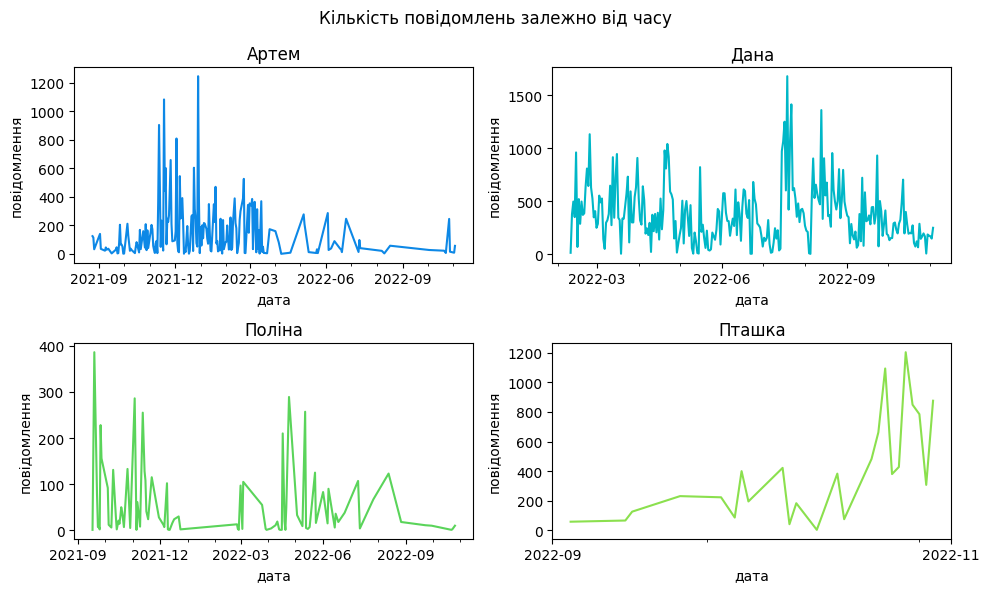

In [246]:
colors = ['#0d88e6', '#00b7c7', '#5ad45a', '#8be04e']
axes = [x for x in range(4)]
fig, ((axes[0], axes[1]), (axes[2], axes[3])) = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

counter = 0
names = ['artem', 'dana', 'polina', 'ptashka']
for name in names:
    draw_plot(get_x_y(number_of_m[name])[0], get_x_y(number_of_m[name])[1], axes[counter],\
              title=labels[name], color=colors[counter])
    counter += 1

plt.suptitle('Кількість повідомлень залежно від часу')
plt.tight_layout()

Через обмеження в 100000 повідомлень при вивантаженні даних, не всі повідомлення з переписки з Даною завантажилися

Тобто це показує, що в період з лютого в нас з нею у переписці було 100 тисяч повідомлень

<a>

Погляньмо на спільний графік

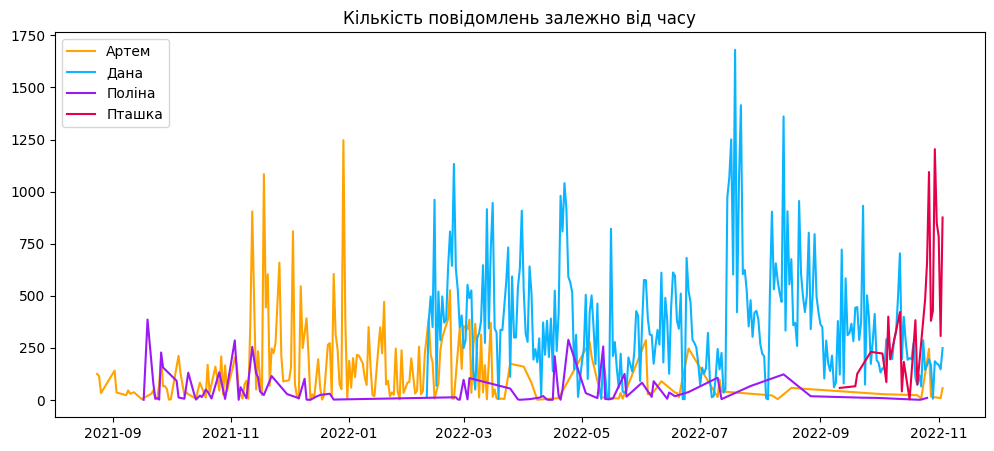

In [249]:
colors = ['#ffa300', '#0bb4ff','#9b19f5', '#e60049']
fig = plt.subplots(figsize =(12,5))

counter = 0
for name in names:
    plt.plot(get_x_y(number_of_m[name])[0], get_x_y(number_of_m[name])[1], color=colors[counter], label=labels[name])
    counter += 1

plt.legend(loc="upper left")
plt.title('Кількість повідомлень залежно від часу')
plt.show()

Отже, можна побачити, що ми спілкувалися активно з Артемом взимку, потім стали спілкуватися менше

З Поліною теж спілкування зменшилося

Проте я почала спілкуватися з Пташкою і, дійсно, можна помітити що за останній час ми багато спілкуємося

Також видно, що в період травень-липень 2022 трошки більше спілкування стало з Поліною й Артемом

З Даною спілкування найбільш стабільне. Оскільки історія наших повідомлень завантажена лише з лютого, то ми можемо робити висновки лише про цей період, хоча ми листувалися активно й раніше в телеграмі

<a id='ner'></a>

### Які іменовані сутності найбільш поширені у переписках?

In [ ]:
nlp = stanza.Pipeline(lang='uk', processors='tokenize,ner')

In [388]:
def get_text(fdist):
    return ' '.join(item[0] for item in fdist)

In [390]:
doc = nlp(get_text(fdists['dana']))

temp = doc
doc = {}
doc['dana'] = temp

In [392]:
for name in names[1:]:
    doc[name] = nlp(get_text(fdists[name]))

In [430]:
def ner(name, ne_type='PERS'):    
    counter = 0
    result = []
    for num in range(len(doc[name].ents)):
        if doc[name].ents[num].type == ne_type:
            if counter > 10: break
            counter += 1
            result.append(doc[name].ents[num].text)
    return result

In [431]:
ner('artem', 'LOC')

['Київ',
 'Україна',
 'Дніпро',
 'Львів',
 'Мелітополь',
 'Іспанія',
 'Німеччина',
 'Тернопіль',
 'Новомосковськ',
 'Троєщина',
 'Тернополь']

In [432]:
ner('polina', 'LOC')

['Київ',
 'Україна',
 'Крим',
 'Мелітополь',
 'Німеччина',
 'Англія',
 'Львів',
 'Херсон',
 'Ростова',
 'Гамбург',
 'Дніпро']

In [433]:
ner('dana', 'LOC')

['Україна',
 'Угорщина',
 'Київ',
 'Закарпаття',
 'Львів',
 'Росія',
 'Словаччина',
 'Будапешт',
 'Дніпро',
 'Польща',
 'Харків']

In [434]:
ner('ptashka', 'LOC')

['Україна',
 'Литва',
 'Англія',
 'Німеччина',
 'Лондон',
 'Вільнюс',
 'Бровари',
 'Мелітополь',
 'Львів',
 'Дніпро',
 'Спеція']

З цих даних я зробила висновок, що найпоширенішими з географічних сутностей є ті, в яких ми перебуваємо на момент спілкування

### Висновок: завдяки дослідженню було знайдено нову інформацію, наприклад, ознаки моєї соціальної активності, час сну, емоційе забарвлення переписок тощо, усе це є корисною інформацію, яку можна і надалі досліджувати, шукаючи кращі методики та інструменти для цього, і яку можна використовувати для змін у своєму житті